Experiments

In [5]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.datacollection import DataCollector

from tqdm import tqdm
import pandas as pd
import numpy as np
from social_force_model import CrowdModel, portrayal
import matplotlib.pyplot as plt

# Helper functions

In [11]:
def scaling_factor(fraction, dimension):
    return int(np.sqrt((fraction * dimension**2)/np.pi))

def plot_csv(file_name1, file_name2, label1, label2, title, yaxis_label="Number of Agents"):
    data1 = pd.read_csv(file_name1)
    data2 = pd.read_csv(file_name2)
        
    # get mean of data
    data_mean1 = data1.mean(axis=1)
    data_mean2 = data2.mean(axis=1)
    
    # get std of data
    data_std1 = data1.std(axis=1)
    data_std2 = data2.std(axis=1)
    
    # plot data
    plt.figure()
    plt.plot(data_mean1.index, data_mean1, label=label1)
    plt.fill_between(data_mean1.index, data_mean1 - data_std1, data_mean1 + data_std1, alpha=0.2)
    plt.plot(data_mean2.index, data_mean2, label=label2)
    plt.fill_between(data_mean2.index, data_mean2 - data_std2, data_mean2 + data_std2, alpha=0.2)
    plt.legend()
    plt.axhline(y=(N-4), color='r', linestyle='--')
    
    plt.title(f"{title}")
    plt.xlabel("Steps")
    plt.ylabel(yaxis_label)
    plt.show()
    
    # plot zoomed in part
    plt.figure()
    plt.plot(data_mean1.index, data_mean1, label=label1)
    plt.fill_between(data_mean1.index, data_mean1 - data_std1, data_mean1 + data_std1, alpha=0.2)
    plt.plot(data_mean2.index, data_mean2, label=label2)
    plt.fill_between(data_mean2.index, data_mean2 - data_std2, data_mean2 + data_std2, alpha=0.2)
    plt.legend()
    plt.axhline(y=(N-4), color='r', linestyle='--')
    plt.xlim(0, 20)
    
    plt.title(f"Zoomed: {title}")
    plt.xlabel("Steps")
    plt.ylabel(yaxis_label)
    plt.show()

# Base model params

In [14]:
#Parameters
dimension = 25
width = dimension
height = dimension

N = int(0.25 * dimension * dimension)
fire_radius = scaling_factor((1/7), dimension)
social_radius = scaling_factor((1/35), dimension)
p_spreading = 0.3
p_spreading_environment = 0.2
p_env_knowledge_params = [3/25, 20/25] # uniform, threshold 1 no knowledge, threshold 2 one exit knowledge.
evacuator_present = False
evacuator_radius = social_radius * 4
fire_avoidance_radius = 1
gumbel_params = [1,0.5,1,0.5] # mean and std of goal_attraction + mean and std of social_repulsion


main_exit_radius = width // 10
emergency_exit_radius = int(width // 13)

exits = [ {"location": (width // 2, height - 1), "radius": width // 10},
          {"location": (0, 0), "radius": width // 13},
          {"location": (width - 1, 0), "radius": width // 13}]
grid = CanvasGrid(portrayal, width, height)

# Basic model runs

In [ ]:
#Run model without visualization
server = ModularServer(CrowdModel, [grid], "Crowd Model", {"width": width, "height": height, "N": N, 
                                                           'p_env_knowledge_params': p_env_knowledge_params, 
                                                           "fire_radius": fire_radius, 'social_radius': social_radius, 
                                                           'p_spreading': p_spreading, 'p_spreading_environment': p_spreading_environment, 
                                                           'exits': exits, 'evacuator_present':evacuator_present, 'evacuator_radius':evacuator_radius, 
                                                           'fire_avoidance_radius': fire_avoidance_radius, 'gumbel_params': gumbel_params})
num_runs = 10

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

all_agents_removed = []
all_agents_know_fire = []
all_exit_knowledge_spread = []
all_change_goal = []
all_agents_know_an_exit = []

# Run the model multiple times
for i in range(num_runs):
    print(f"Running model {i + 1}...")
    server.model = CrowdModel(width, height, N, p_env_knowledge_params, fire_radius, social_radius, p_spreading, p_spreading_environment, exits, evacuator_present, evacuator_radius, fire_avoidance_radius, gumbel_params)  ##### CHANGE PARAMS HERE
    server.model.run_model()  # Run the model
    
    data_new = server.model.datacollector.get_model_vars_dataframe()
    
    all_agents_removed.append(data_new['Agents Removed'])
    all_agents_know_fire.append(data_new["Agents Know Fire"])
    all_exit_knowledge_spread.append(data_new["Exit Knowledge Spread"])
    all_change_goal.append(data_new["Change Goal"])
    # all_agents_know_an_exit.append(data_new["Exit Knowledge"])  ###### ADD COLUMN NAME HERE

# Convert to dataframe 
df_agents_removed = pd.concat(all_agents_removed, axis=1)
df_agents_know_fire = pd.concat(all_agents_know_fire, axis=1)
df_exit_knowledge_spread = pd.concat(all_exit_knowledge_spread, axis=1)
df_change_goal = pd.concat(all_change_goal, axis=1)
# df_agents_know_an_exit = pd.concat(all_agents_know_an_exit, axis=1) ###### ADD DF HERE

# Save each metric to a separate CSV file
df_agents_removed.to_csv("basic_removed.csv", index=False)
df_agents_know_fire.to_csv("basic_know_fire.csv", index=False)
df_exit_knowledge_spread.to_csv("basic_exit_spread.csv", index=False)
df_change_goal.to_csv("basic_change_goal.csv", index=False)
# df_agents_know_an_exit.to_csv("basic_know_exit.csv", index=False) ###### ADD FILE NAME HERE

print("All data saved successfully!")

# Intervention 0: No prior knowledge

In [19]:
p_env_knowledge_params_no_prior = [1, 1]

#Run model without visualization
server = ModularServer(CrowdModel, [grid], "Crowd Model", {"width": width, "height": height, "N": N, 'p_env_knowledge_params': p_env_knowledge_params_no_prior, "fire_radius": fire_radius, 'social_radius': social_radius, 'p_spreading': p_spreading, 'p_spreading_environment': p_spreading_environment, 'exits': exits})

num_runs = 10

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

all_agents_removed = []
all_agents_know_fire = []
all_exit_knowledge_spread = []
all_change_goal = []
all_agents_know_an_exit = []

# Run the model multiple times
for i in range(num_runs):
    print(f"Running model {i + 1}...")
    server.model = CrowdModel(width, height, N, p_env_knowledge_params_no_prior, fire_radius, social_radius, p_spreading, p_spreading_environment, exits)   ###
    server.model.run_model()  # Run the model
    
    data_new = server.model.datacollector.get_model_vars_dataframe()
    
    all_agents_removed.append(data_new['Agents Removed'])
    all_agents_know_fire.append(data_new["Agents Know Fire"])
    all_exit_knowledge_spread.append(data_new["Exit Knowledge Spread"])
    all_change_goal.append(data_new["Change Goal"])
    # all_agents_know_an_exit.append(data_new["Exit Knowledge"])  ###

# Convert to dataframe 
df_agents_removed = pd.concat(all_agents_removed, axis=1)
df_agents_know_fire = pd.concat(all_agents_know_fire, axis=1)
df_exit_knowledge_spread = pd.concat(all_exit_knowledge_spread, axis=1)
df_change_goal = pd.concat(all_change_goal, axis=1)
# df_agents_know_an_exit = pd.concat(all_agents_know_an_exit, axis=1)  ###

# Save each metric to a separate CSV file
df_agents_removed.to_csv("no_prior_removed.csv", index=False)
df_agents_know_fire.to_csv("no_prior_know_fire.csv", index=False)
df_exit_knowledge_spread.to_csv("no_prior_exit_spread.csv", index=False)
df_change_goal.to_csv("no_prior_change_goal.csv", index=False)
# df_agents_know_an_exit.to_csv("no_prior_know_exit.csv", index=False)  ###

print("All data saved successfully!")

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Running model 1...
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Agent 149 reached the goal!
Agent 68 reached the goal!
Step: 20
Step: 21
Agent 117 reached the goal!
Step: 22
Step: 23
Agent 71 reached the goal!
Step: 24
Agent 80 reached the goal!
Step: 25
Step: 26
Agent 142 reached the goal!
Agent 143 reached the goal!
Step: 27
Agent 74 reached the goal!
Step: 28
Agent 136 reached the goal!
Step: 29
Agent 48 reached the goal!
Agent 20 reached the goal!
Agent 21 reached the goal!
Step: 30
Agent 12 reached the goal!
Agent 122 reached the goal!
Agent 73 reached the goal!
Step: 31
Agent 26 reached the goal!
Agent 130 reached the goal!
Step: 32
Step: 33
Agent 43 reached the goal!
Step: 34
Agent 1 reached the goal!
Step: 35
Step: 36
Step: 37
Agent 140 reached the goal!
Step: 38
Agent 40 reached the goal!
Step: 39
Step: 40
Agent 3 reached the goal!
Agent 54 reached the goal!
Ste

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Agent 64 reached the goal!
Step: 10
Step: 11
Step: 12
Agent 122 reached the goal!
Step: 13
Step: 14
Agent 11 reached the goal!
Agent 38 reached the goal!
Step: 15
Agent 41 reached the goal!
Agent 1 reached the goal!
Step: 16
Agent 27 reached the goal!
Agent 119 reached the goal!
Agent 80 reached the goal!
Step: 17
Step: 18
Agent 65 reached the goal!
Step: 19
Step: 20
Step: 21
Step: 22
Agent 10 reached the goal!
Step: 23
Agent 135 reached the goal!
Step: 24
Step: 25
Agent 75 reached the goal!
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Agent 94 reached the goal!
Step: 34
Agent 83 reached the goal!
Step: 35
Step: 36
Agent 52 reached the goal!
Step: 37
Agent 93 reached the goal!
Step: 38
Step: 39
Step: 40
Agent 55 reached the goal!
Step: 41
Step: 42
Agent 96 reached the goal!
Step: 43
Step: 44
Agent 137 reached the goal!
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Agent 14 reach

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Agent 23 reached the goal!
Step: 58
Step: 59
Step: 60
Agent 76 reached the goal!
Step: 61
Agent 139 reached the goal!
Step: 62
Agent 15 reached the goal!
Step: 63
Agent 101 reached the goal!
Step: 64
Step: 65
Step: 66
Step: 67
Agent 145 reached the goal!
Step: 68
Agent 40 reached the goal!
Agent 32 reached the goal!
Step: 69
Step: 70
Agent 149 reached the goal!
Step: 71
Agent 110 reached the goal!
Step: 72
Agent 43 reached the goal!
Agent 128 reached the goal!
Step: 73
Agent 150 reached the goal!
Agent 0 reached the goal!
Step: 74
Agent 88 reached the goal!
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Agent 140 reached the goal!
Step: 81
Step: 82
Step: 83
Step: 84
Agent 54 reached the goal!
Agent 113 reached the goal!
Step: 85
Step: 86
Agent 133 reached the goal!
Step: 87
Agent 79 reached the goal!
Agent 89 reached the goal!
Agent 22 reached the goal!
Agent 98 reached the goal!
Step: 88
Step: 89
Agent 129 reached the goal!
Step: 90
Step: 91
Agent 69 reached the goal!
Step: 92


/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Agent 50 reached the goal!
Step: 11
Agent 144 reached the goal!
Step: 12
Agent 77 reached the goal!
Step: 13
Step: 14
Step: 15
Agent 115 reached the goal!
Step: 16
Agent 28 reached the goal!
Step: 17
Agent 137 reached the goal!
Step: 18
Step: 19
Step: 20
Step: 21
Agent 33 reached the goal!
Step: 22
Step: 23


/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Agent 30 reached the goal!
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Agent 78 reached the goal!
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Agent 106 reached the goal!
Step: 63
Step: 64
Agent 91 reached the goal!
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Agent 26 reached the goal!
Step: 78
Step: 79
Agent 130 reached the goal!
Step: 80
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Agent 125 reached the goal!
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Agent 64 reached the goal!
Step: 99
Step: 100
Step: 101
Step: 102
Step: 103
Step: 104
Step: 105
Step: 106
Step: 107
Step: 108
Step: 1

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 6
Step: 7
Step: 8
Agent 110 reached the goal!
Step: 9
Agent 117 reached the goal!
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Agent 8 reached the goal!
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Agent 55 reached the goal!
Step: 24
Step: 25
Step: 26
Step: 27
Agent 79 reached the goal!
Step: 28
Step: 29
Agent 99 reached the goal!
Agent 59 reached the goal!
Agent 25 reached the goal!
Step: 30
Agent 104 reached the goal!
Agent 71 reached the goal!
Step: 31
Step: 32
Agent 26 reached the goal!
Step: 33
Step: 34
Agent 134 reached the goal!
Step: 35
Step: 36
Agent 130 reached the goal!
Step: 37
Step: 38
Step: 39
Agent 151 reached the goal!
Agent 111 reached the goal!
Step: 40
Agent 32 reached the goal!
Step: 41
Agent 145 reached the goal!
Agent 27 reached the goal!
Step: 42
Agent 69 reached the goal!
Step: 43
Step: 44
Step: 45
Agent 66 reached the goal!
Step: 46
Step: 47
Agent 147 reached the goal!
Step: 48
Step: 49
Agent 128 reached the goal!
Agent

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Agent 25 reached the goal!
Step: 42
Step: 43
Step: 44


/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Step: 45
Step: 46
Agent 96 reached the goal!
Step: 47
Agent 67 reached the goal!
Step: 48
Step: 49
Agent 129 reached the goal!
Step: 50
Agent 2 reached the goal!
Agent 66 reached the goal!
Step: 51
Agent 16 reached the goal!
Step: 52
Agent 109 reached the goal!
Step: 53
Step: 54
Agent 65 reached the goal!
Step: 55
Step: 56
Agent 18 reached the goal!
Step: 57
Agent 17 reached the goal!
Step: 58
Agent 7 reached the goal!
Step: 59
Step: 60
Agent 95 reached the goal!
Agent 91 reached the goal!
Step: 61
Agent 90 reached the goal!
Step: 62
Step: 63
Agent 36 reached the goal!
Agent 104 reached the goal!
Step: 64
Agent 1 reached the goal!
Step: 65
Step: 66
Step: 67
Step: 68
Agent 60 reached the goal!
Step: 69
Agent 138 reached the goal!
Agent 142 reached the goal!
Step: 70
Step: 71
Step: 72
Step: 73
Agent 14 reached the goal!
Step: 74
Step: 75
Agent 35 reached the goal!
Step: 76
Agent 113 reached the goal!
Step: 77
Agent 146 reached the goal!
Agent 130 reached the goal!
Step: 78
Agent 3 reache

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Agent 82 reached the goal!
Agent 44 reached the goal!
Step: 27
Step: 28
Agent 12 reached the goal!
Step: 29
Agent 79 reached the goal!
Step: 30
Step: 31
Agent 132 reached the goal!
Step: 32
Agent 45 reached the goal!
Step: 33
Step: 34
Agent 114 reached the goal!
Step: 35
Agent 150 reached the goal!
Step: 36
Agent 149 reached the goal!
Step: 37
Agent 50 reached the goal!
Step: 38
Step: 39
Step: 40
Agent 48 reached the goal!
Step: 41
Step: 42
Step: 43
Agent 5 reached the goal!
Step: 44
Agent 22 reached the goal!
Step: 45
Agent 108 reached the goal!
Step: 46
Step: 47
Agent 65 reached the goal!
Agent 34 reached the goal!
Step: 48
Agent 38 reached the goal!
Agent 29 reached the goal!
Step: 49
Agent 57 reached the goal!
Agent 76 reached the goal!
Step: 50
Agent 106 reached the goal!
Step: 51
Step: 52
Agent 141

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Agent 137 reached the goal!
Agent 109 reached the goal!
Step: 29
Agent 73 reached the goal!
Step: 30
Step: 31
Step: 32
Agent 84 reached the goal!
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Agent 140 reached the goal!
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Agent 132 reached the goal!
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Agent 121 reached the goal!
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Agent 75 reached the goal!
Step: 65
Step: 66
Step: 67
Agent 46 reached the goal!
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Agent 32 reached the goal!
Step: 77
Step: 78
Agent 112 reached the goal!
Step: 79
Step: 80
St

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Agent 8 reached the goal!
Step: 35
Step: 36
Agent 33 reached the goal!
Step: 37
Step: 38
Agent 56 reached the goal!
Agent 25 reached the goal!
Agent 36 reached the goal!
Step: 39
Step: 40
Agent 20 reached the goal!
Step: 41
Step: 42
Agent 40 reached the goal!
Step: 43
Step: 44
Agent 103 reached the goal!
Step: 45
Step: 46
Agent 38 reached the goal!
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Agent 67 reached the goal!
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Agent 71 reached the goal!
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80


/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10


/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Step: 11
Step: 12
Agent 129 reached the goal!
Agent 66 reached the goal!
Step: 13
Agent 112 reached the goal!
Step: 14
Step: 15
Agent 56 reached the goal!
Step: 16
Agent 53 reached the goal!
Agent 22 reached the goal!
Step: 17
Agent 105 reached the goal!
Step: 18
Agent 28 reached the goal!
Step: 19
Agent 126 reached the goal!
Step: 20
Agent 36 reached the goal!
Agent 85 reached the goal!
Step: 21
Agent 144 reached the goal!
Step: 22
Step: 23
Agent 76 reached the goal!
Step: 24
Step: 25
Agent 16 reached the goal!
Step: 26
Agent 7 reached the goal!
Step: 27
Agent 61 reached the goal!
Step: 28
Agent 21 reached the goal!
Step: 29
Step: 30
Agent 40 reached the goal!
Agent 88 reached the goal!
Step: 31
Step: 32
Agent 34 reached the goal!
Agent 104 reached the goal!
Step: 33
Step: 34
Agent 69 reached the goal!
Step: 35
Agent 130 reached the goal!
Step: 36
Agent 121 reached the goal!
Step: 37
Agent 63 reached the goal!
Step: 38
Agent 103 reached the goal!
Agent 137 reached the goal!
Step: 39
A

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Agent 5 reached the goal!
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Agent 149 reached the goal!
Step: 22
Step: 23
Step: 24
Step: 25
Agent 1 reached the goal!
Step: 26
Agent 121 reached the goal!
Agent 20 reached the goal!
Step: 27
Step: 28
Agent 151 reached the goal!
Step: 29
Agent 126 reached the goal!
Step: 30
Step: 31
Agent 66 reached the goal!
Step: 32
Agent 91 reached the goal!
Step: 33
Step: 34
Agent 103 reached the goal!
Step: 35
Agent 137 reached the goal!
Step: 36
Step: 37
Agent 118 reached the goal!
Step: 38
Agent 119 reached the goal!
Agent 128 reached the goal!
Step: 39
Agent 106 reached the goal!
Step: 40
Step: 41
Agent 98 reached the goal!
Step: 42
Step: 43
Agent 31 reached the goal!
Step: 44
Step: 45
Agent 62 reached the goal!
Step: 46
Step: 47
Step: 48
Agent 80 reached the goal!
Step: 49
Step: 50
Step: 51
Agent 131 reached the goal!
Step: 52


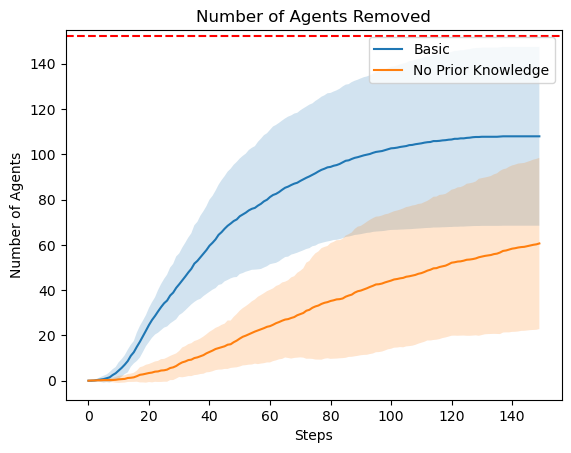

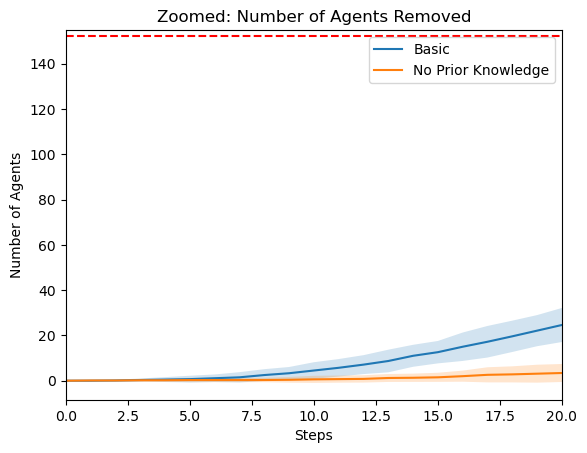

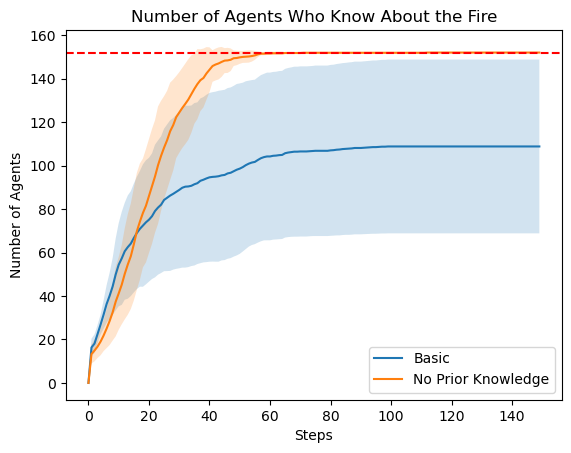

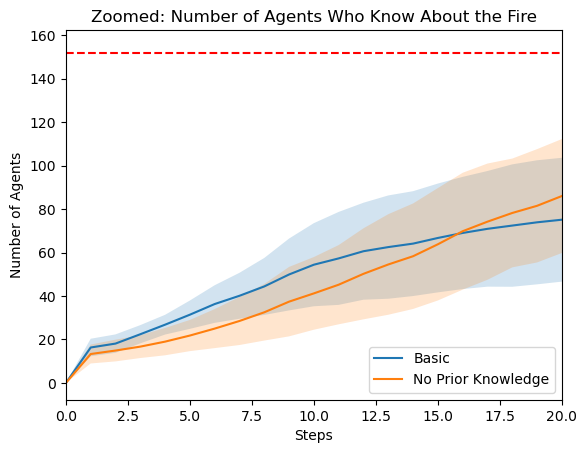

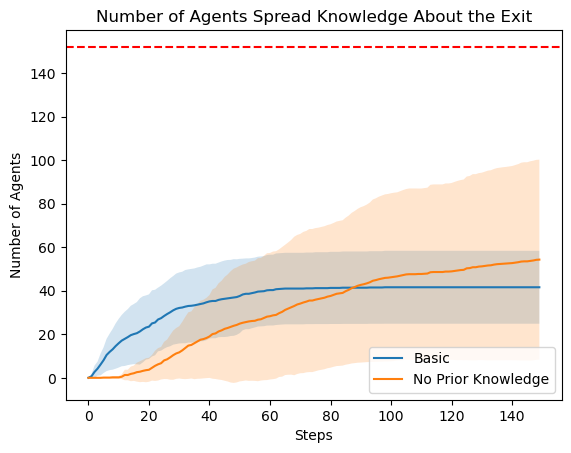

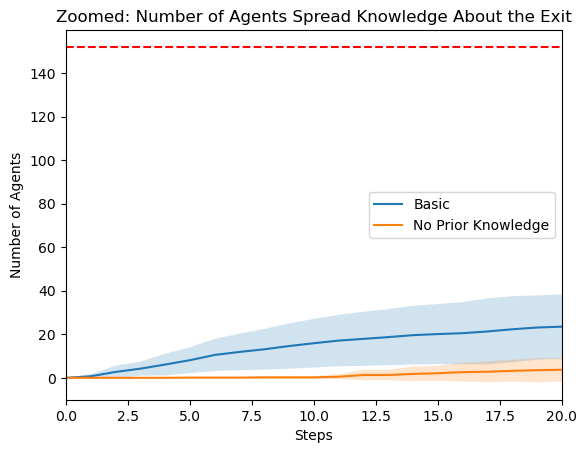

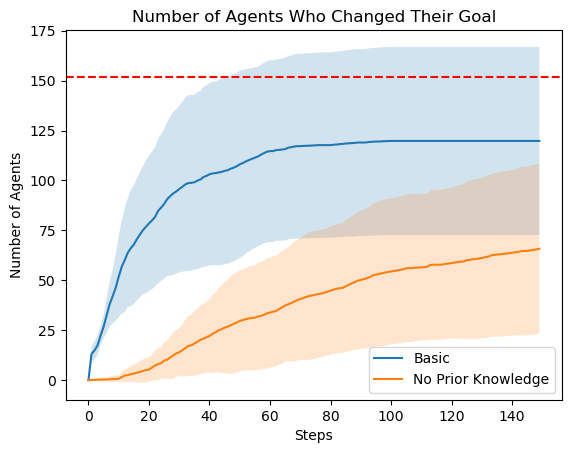

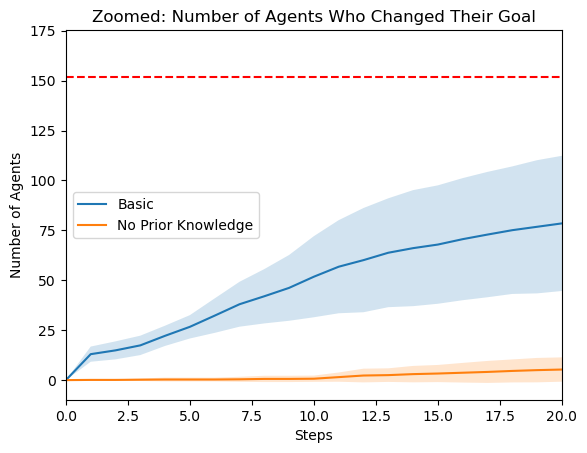

FileNotFoundError: [Errno 2] No such file or directory: 'basic_know_exit.csv'

In [20]:
plot_csv("basic_removed.csv", "no_prior_removed.csv", "Basic", "No Prior Knowledge", "Number of Agents Removed")
plot_csv("basic_know_fire.csv", "no_prior_know_fire.csv", "Basic", "No Prior Knowledge", "Number of Agents Who Know About the Fire")
plot_csv("basic_exit_spread.csv", "no_prior_exit_spread.csv", "Basic", "No Prior Knowledge", "Number of Agents Spread Knowledge About the Exit")
plot_csv("basic_change_goal.csv", "no_prior_change_goal.csv", "Basic", "No Prior Knowledge", "Number of Agents Who Changed Their Goal")
plot_csv("basic_know_exit.csv", "no_prior_know_exit.csv", "Basic", "No Prior Knowledge", "Number of Agents Who Know About an Exit")

# Intervention 1: signage

In [21]:
#Increase the radius of doors
main_exit_radius_sign = main_exit_radius * 10
emergency_exit_radius_sign = emergency_exit_radius * 10

exits_sign = [ {"location": (0, height - 1), "radius": main_exit_radius_sign},
          {"location": (width - 1, 0), "radius": emergency_exit_radius_sign},
          {"location": (width - 1, height - 1), "radius": emergency_exit_radius_sign}]

In [22]:
#Run model without visualization
server = ModularServer(CrowdModel, [grid], "Crowd Model", {"width": width, "height": height, "N": N, 'p_env_knowledge_params': p_env_knowledge_params, "fire_radius": fire_radius, 'social_radius': social_radius, 'p_spreading': p_spreading, 'p_spreading_environment': p_spreading_environment, 'exits': exits_sign})

num_runs = 10

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

all_agents_removed = []
all_agents_know_fire = []
all_exit_knowledge_spread = []
all_change_goal = []

# Run the model multiple times
for i in range(num_runs):
    print(f"Running model {i + 1}...")
    server.model = CrowdModel(width, height, N, p_env_knowledge_params, fire_radius, social_radius, p_spreading, p_spreading_environment, exits_sign)
    server.model.run_model()  # Run the model
    
    data_new = server.model.datacollector.get_model_vars_dataframe()
    
    all_agents_removed.append(data_new['Agents Removed'])
    all_agents_know_fire.append(data_new["Agents Know Fire"])
    all_exit_knowledge_spread.append(data_new["Exit Knowledge Spread"])
    all_change_goal.append(data_new["Change Goal"])

# Convert to dataframe 
df_agents_removed = pd.concat(all_agents_removed, axis=1)
df_agents_know_fire = pd.concat(all_agents_know_fire, axis=1)
df_exit_knowledge_spread = pd.concat(all_exit_knowledge_spread, axis=1)
df_change_goal = pd.concat(all_change_goal, axis=1)

# Save each metric to a separate CSV file
df_agents_removed.to_csv("signage_removed.csv", index=False)
df_agents_know_fire.to_csv("signage_know_fire.csv", index=False)
df_exit_knowledge_spread.to_csv("signage_exit_spread.csv", index=False)
df_change_goal.to_csv("signage_change_goal.csv", index=False)

print("All data saved successfully!")

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Running model 1...
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Agent 53 reached the goal!
Agent 137 reached the goal!
Step: 7
Agent 9 reached the goal!
Agent 61 reached the goal!
Step: 8
Agent 8 reached the goal!
Agent 42 reached the goal!
Step: 9
Agent 107 reached the goal!
Agent 32 reached the goal!
Agent 115 reached the goal!
Step: 10
Agent 4 reached the goal!
Agent 26 reached the goal!
Step: 11
Agent 138 reached the goal!
Agent 34 reached the goal!
Step: 12
Agent 93 reached the goal!
Agent 66 reached the goal!
Agent 30 reached the goal!
Step: 13
Agent 94 reached the goal!
Agent 7 reached the goal!
Agent 144 reached the goal!
Step: 14
Agent 23 reached the goal!
Agent 24 reached the goal!
Agent 119 reached the goal!
Step: 15
Agent 25 reached the goal!
Agent 37 reached the goal!
Agent 64 reached the goal!
Agent 89 reached the goal!
Step: 16
Agent 106 reached the goal!
Agent 40 reached the goal!
Step: 17
Agent 38 reached the goal!
Agent 35 reached the goal!
Agent 120 reached the go

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Step: 3
Step: 4
Agent 127 reached the goal!
Agent 5 reached the goal!
Step: 5
Agent 98 reached the goal!
Step: 6
Agent 135 reached the goal!
Step: 7
Agent 63 reached the goal!
Step: 8
Step: 9
Step: 10
Agent 25 reached the goal!
Step: 11
Step: 12
Step: 13
Agent 85 reached the goal!
Agent 22 reached the goal!
Step: 14
Agent 2 reached the goal!
Step: 15
Step: 16
Step: 17
Agent 45 reached the goal!
Agent 72 reached the goal!
Agent 57 reached the goal!
Step: 18
Agent 95 reached the goal!
Step: 19
Agent 54 reached the goal!
Agent 105 reached the goal!
Agent 16 reached the goal!
Step: 20
Agent 113 reached the goal!
Agent 103 reached the goal!
Step: 21
Agent 9 reached the goal!
Agent 65 reached the goal!
Agent 4 reached the goal!
Agent 33 reached the goal!
Step: 22
Agent 122 reached the goal!
Step: 23
Agent 128 reached the goal!
Agent 8 reached the goal!
Agent 31 reached the goal!
Step: 24
Agent 132 reached the goal!
Agent 139 reached the goal!
Step: 25
Agent 112 reached the goal!
Agent 96 rea

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Agent 85 reached the goal!
Step: 8
Agent 24 reached the goal!
Agent 57 reached the goal!
Step: 9
Agent 66 reached the goal!
Step: 10
Agent 28 reached the goal!
Agent 87 reached the goal!
Agent 119 reached the goal!
Step: 11
Step: 12
Agent 111 reached the goal!
Step: 13
Agent 129 reached the goal!
Agent 21 reached the goal!
Agent 62 reached the goal!
Agent 39 reached the goal!
Agent 38 reached the goal!
Step: 14
Agent 12 reached the goal!
Agent 1 reached the goal!
Agent 121 reached the goal!
Step: 15
Agent 90 reached the goal!
Agent 96 reached the goal!
Step: 16
Agent 43 reached the goal!
Agent 116 reached the goal!
Agent 30 reached the goal!
Agent 25 reached the goal!
Step: 17
Agent 59 reached the goal!
Agent 122 reached the goal!
Agent 20 reached the goal!
Step: 18
Agent 132 reached the goal!
Agent 19 reached the goal!
Agent 145 reached the goal!
Agent 84 reached the goal!
Agent 7 reached the goal!
Step: 19
Agent 56 reached the g

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 3
Agent 87 reached the goal!
Step: 4
Agent 68 reached the goal!
Agent 102 reached the goal!
Step: 5
Agent 114 reached the goal!
Step: 6
Step: 7
Agent 79 reached the goal!
Step: 8
Agent 28 reached the goal!
Agent 69 reached the goal!
Step: 9
Step: 10
Agent 133 reached the goal!
Step: 11
Agent 145 reached the goal!
Step: 12
Step: 13
Agent 135 reached the goal!
Agent 119 reached the goal!
Step: 14
Step: 15
Agent 45 reached the goal!
Step: 16
Step: 17
Agent 82 reached the goal!
Step: 18
Agent 65 reached the goal!
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Agent 81 reached the goal!
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
St

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Agent 141 reached the goal!


/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Agent 18 reached the goal!
Agent 12 reached the goal!
Agent 78 reached the goal!
Step: 9
Agent 77 reached the goal!
Step: 10
Agent 104 reached the goal!
Agent 65 reached the goal!
Agent 75 reached the goal!
Step: 11
Agent 73 reached the goal!
Agent 61 reached the goal!
Agent 76 reached the goal!
Step: 12
Agent 8 reached the goal!
Step: 13
Agent 85 reached the goal!
Agent 60 reached the goal!
Agent 144 reached the goal!
Step: 14
Agent 88 reached the goal!
Agent 30 reached the goal!
Step: 15
Agent 3 reached the goal!
Agent 131 reached the goal!
Agent 29 reached the goal!
Agent 6 reached the goal!
Agent 45 reached the goal!
Agent 124 reached the goal!
Step: 16
Agent 54 reached the goal!
Agent 50 reached the goal!
Step: 17
Agent 137 reached the goal!
Agent 110 reached the goal!
Agent 100 reached the goal!
Step: 18
Agent 87 reached the goal!
Step: 19
Agent 13 reached the goal!
Agent 37 reached the goal!
Agent 59 reached the goal!
Agent 53 reached the goal!
Agent 56 reached the goal!
Step: 2

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 4
Agent 21 reached the goal!
Agent 67 reached the goal!
Step: 5
Step: 6
Agent 5 reached the goal!
Step: 7
Agent 111 reached the goal!
Step: 8
Step: 9
Step: 10
Step: 11
Agent 150 reached the goal!
Step: 12
Step: 13
Agent 11 reached the goal!
Step: 14
Step: 15
Agent 75 reached the goal!
Step: 16
Agent 37 reached the goal!
Agent 140 reached the goal!
Step: 17
Agent 92 reached the goal!
Step: 18
Agent 16 reached the goal!
Agent 56 reached the goal!
Step: 19
Agent 1 reached the goal!
Agent 88 reached the goal!
Step: 20
Step: 21
Agent 82 reached the goal!
Step: 22
Agent 19 reached the goal!
Agent 36 reached the goal!
Step: 23
Agent 103 reached the goal!
Agent 62 reached the goal!
Step: 24
Agent 136 reached the goal!
Agent 123 reached the goal!
Step: 25
Agent 142 reached the goal!
Agent 2 reached the goal!
Agent 6 reached the goal!
Step: 26
Step: 27
Agent 77 reached the goal!
Agent 139 reached the goal!
Step: 28
Step: 29
Agent 146 reached the goal!
Agent 122 reached the goal!
Step: 30
A

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Agent 31 reached the goal!
Step: 7
Agent 139 reached the goal!
Step: 8
Agent 74 reached the goal!
Step: 9
Agent 33 reached the goal!
Agent 97 reached the goal!
Step: 10
Agent 0 reached the goal!
Agent 63 reached the goal!
Step: 11
Agent 142 reached the goal!
Step: 12
Agent 125 reached the goal!
Step: 13
Agent 13 reached the goal!
Agent 32 reached the goal!
Step: 14
Agent 140 reached the goal!
Agent 107 reached the goal!
Agent 5 reached the goal!
Agent 70 reached the goal!
Step: 15


/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Agent 25 reached the goal!
Agent 124 reached the goal!
Step: 16
Agent 118 reached the goal!
Agent 134 reached the goal!
Agent 68 reached the goal!
Agent 75 reached the goal!
Step: 17
Agent 98 reached the goal!
Agent 34 reached the goal!
Agent 69 reached the goal!
Agent 151 reached the goal!
Agent 120 reached the goal!
Agent 148 reached the goal!
Step: 18
Agent 121 reached the goal!
Agent 22 reached the goal!
Step: 19
Agent 111 reached the goal!
Agent 18 reached the goal!
Agent 10 reached the goal!
Agent 110 reached the goal!
Step: 20
Agent 112 reached the goal!
Agent 3 reached the goal!
Agent 49 reached the goal!
Step: 21
Agent 53 reached the goal!
Agent 42 reached the goal!
Step: 22
Agent 47 reached the goal!
Agent 39 reached the goal!
Step: 23
Agent 16 reached the goal!
Agent 62 reached the goal!
Step: 24
Agent 141 reached the goal!
Agent 41 reached the goal!
Agent 114 reached the goal!
Agent 58 reached the goal!
Agent 100 reached the goal!
Step: 25
Agent 116 reached the goal!
Agent 

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 1
Step: 2
Step: 3
Step: 4
Agent 73 reached the goal!
Step: 5
Agent 13 reached the goal!
Step: 6
Agent 33 reached the goal!
Agent 57 reached the goal!
Step: 7
Agent 38 reached the goal!
Step: 8
Agent 7 reached the goal!
Step: 9
Agent 49 reached the goal!
Agent 130 reached the goal!
Step: 10
Step: 11
Agent 86 reached the goal!
Agent 62 reached the goal!
Step: 12
Step: 13
Step: 14
Step: 15
Agent 103 reached the goal!
Agent 100 reached the goal!
Step: 16
Agent 64 reached the goal!
Agent 96 reached the goal!
Agent 74 reached the goal!
Agent 67 reached the goal!
Step: 17
Agent 55 reached the goal!
Agent 19 reached the goal!
Step: 18
Agent 91 reached the goal!
Agent 88 reached the goal!
Agent 44 reached the goal!
Step: 19
Agent 128 reached the goal!
Agent 50 reached the goal!
Agent 24 reached the goal!
Agent 125 reached the goal!
Step: 20
Agent 81 reached the goal!
Agent 94 reached the goal!
Agent 131 reached the goal!
Step: 21
Agent 85 reached the goal!
Agent 101 reached the goal!
Agen

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Agent 125 reached the goal!
Agent 104 reached the goal!
Step: 9
Step: 10
Agent 72 reached the goal!
Agent 88 reached the goal!
Step: 11
Agent 93 reached the goal!
Step: 12
Agent 28 reached the goal!
Agent 29 reached the goal!
Step: 13
Agent 71 reached the goal!
Agent 18 reached the goal!
Step: 14
Agent 131 reached the goal!
Agent 15 reached the goal!
Step: 15
Agent 3 reached the goal!
Agent 94 reached the goal!
Step: 16
Agent 47 reached the goal!
Agent 91 reached the goal!
Step: 17
Agent 127 reached the goal!
Agent 70 reached the goal!
Step: 18
Agent 123 reached the goal!
Step: 19
Step: 20
Agent 76 reached the goal!
Agent 78 reached the goal!
Step: 21
Step: 22
Agent 110 reached the goal!
Agent 85 reached the goal!
Step: 23
Step: 24
Agent 35 reached the goal!
Agent 51 reached the goal!
Agent 126 reached the goal!
Step: 25
Agent 147 reached the goal!
Step: 26
Agent 57 reached the goal!
Step: 27
Agent 112 reached the goal!
Agent 82 reached t

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Agent 135 reached the goal!
Step: 13
Agent 78 reached the goal!
Agent 142 reached the goal!
Step: 14
Agent 24 reached the goal!
Step: 15
Agent 96 reached the goal!
Step: 16
Agent 102 reached the goal!
Step: 17
Agent 140 reached the goal!
Agent 107 reached the goal!
Step: 18
Agent 21 reached the goal!
Step: 19
Agent 89 reached the goal!
Agent 46 reached the goal!
Step: 20
Agent 129 reached the goal!
Agent 79 reached the goal!
Step: 21
Agent 143 reached the goal!
Step: 22
Agent 35 reached the goal!
Agent 63 reached the goal!
Step: 23
Agent 12 reached the goal!
Step: 24
Agent 41 reached the goal!
Step: 25
Agent 20 reached the goal!
Step: 26
Agent 136 reached the goal!


/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Agent 7 reached the goal!
Agent 56 reached the goal!
Agent 30 reached the goal!
Step: 27
Agent 16 reached the goal!
Agent 68 reached the goal!
Agent 44 reached the goal!
Step: 28
Agent 84 reached the goal!
Agent 118 reached the goal!
Step: 29
Agent 40 reached the goal!
Agent 55 reached the goal!
Agent 144 reached the goal!
Step: 30
Agent 88 reached the goal!
Step: 31
Agent 115 reached the goal!
Agent 69 reached the goal!
Agent 113 reached the goal!
Agent 60 reached the goal!
Agent 146 reached the goal!
Step: 32
Agent 22 reached the goal!
Step: 33
Agent 90 reached the goal!
Agent 148 reached the goal!
Agent 62 reached the goal!
Step: 34
Agent 1 reached the goal!
Agent 122 reached the goal!
Agent 48 reached the goal!
Agent 34 reached the goal!
Agent 32 reached the goal!
Agent 104 reached the goal!
Step: 35
Agent 0 reached the goal!
Agent 65 reached the goal!
Agent 25 reached the goal!
Agent 130 reached the goal!
Agent 81 reached the goal!
Agent 103 reached the goal!
Step: 36
Agent 39 rea

Visualization (works?):

In [9]:
# server = ModularServer(CrowdModel, [grid], "Crowd Model", {"width": width, "height": height, "N": N, "fire_radius": fire_radius, 'social_radius': social_radius, 'p_spreading': p_spreading, 'p_spreading_environment': p_spreading_environment, 'p_env_knowledge_params': p_env_knowledge_params, 'exits': exits})
# server.port = 9987
# server.launch()

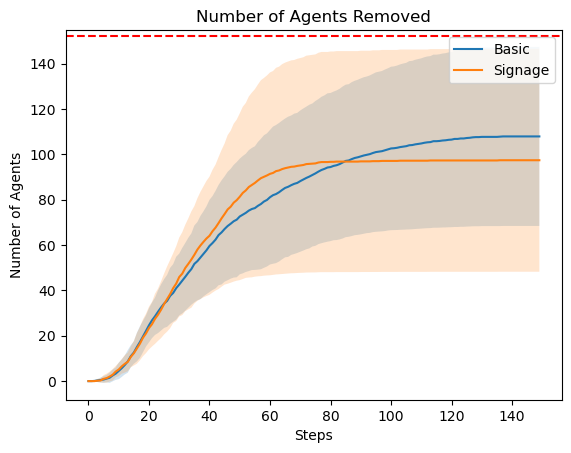

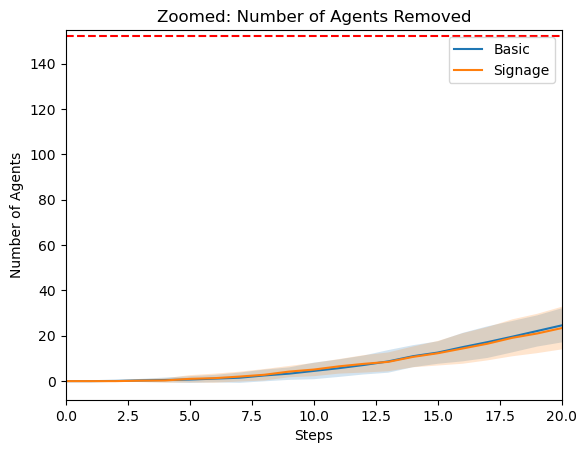

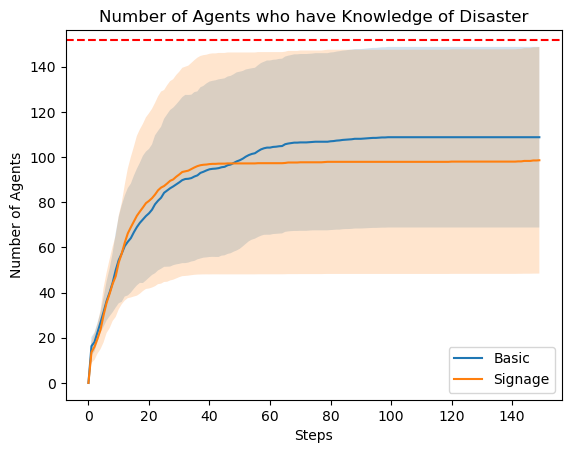

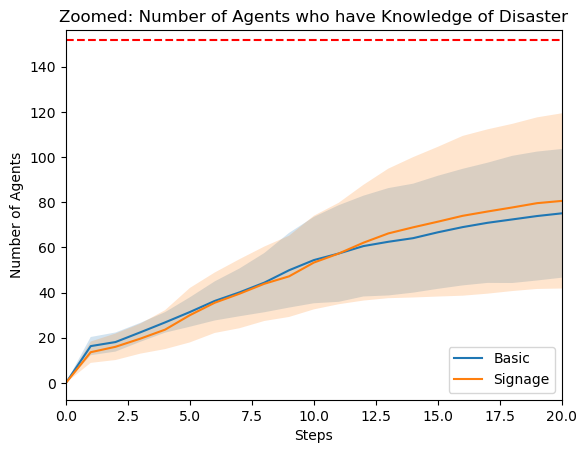

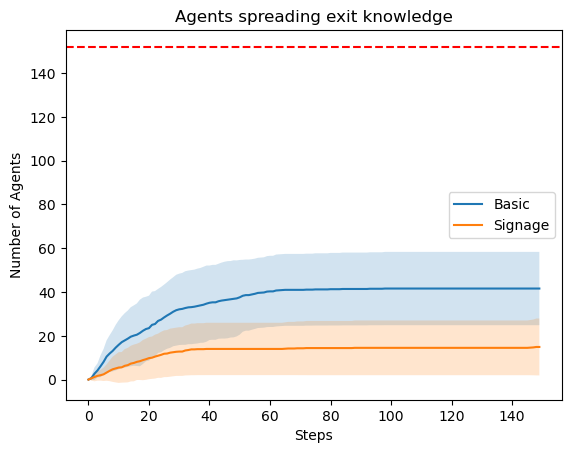

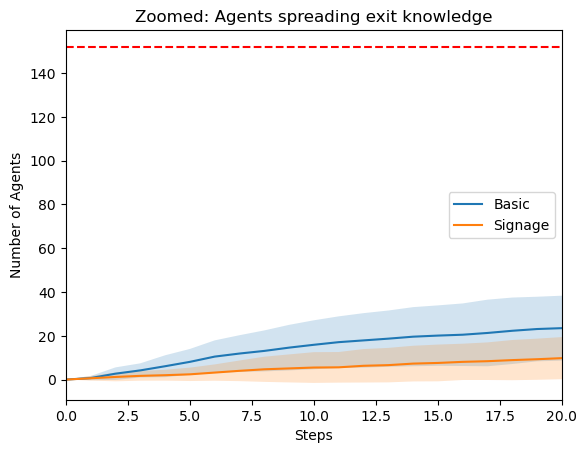

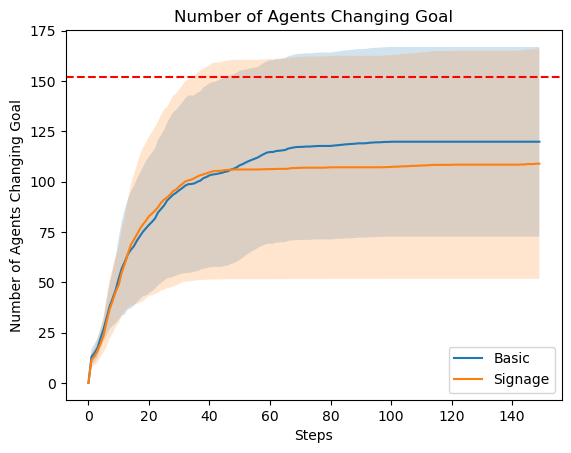

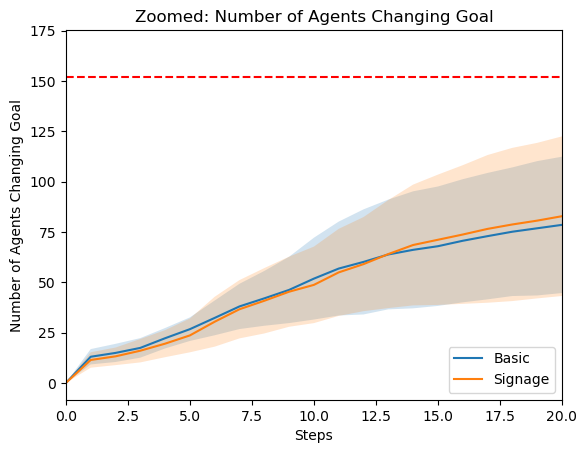

In [24]:
plot_csv("basic_removed.csv", "signage_removed.csv", "Basic", "Signage", "Number of Agents Removed")
plot_csv("basic_know_fire.csv", "signage_know_fire.csv", "Basic", "Signage", "Number of Agents who have Knowledge of Disaster")
plot_csv("basic_exit_spread.csv", "signage_exit_spread.csv", "Basic", "Signage", "Agents spreading exit knowledge")
plot_csv("basic_change_goal.csv", "signage_change_goal.csv", "Basic", "Signage", "Number of Agents Changing Goal", "Number of Agents Changing Goal")

# Intervention 2: announcement

In [25]:
fire_radius_announcement = np.inf

In [26]:
#Run model without visualization
server = ModularServer(CrowdModel, [grid], "Crowd Model", {"width": width, "height": height, "N": N, 'p_env_knowledge_params': p_env_knowledge_params, "fire_radius": fire_radius_announcement, 'social_radius': social_radius, 'p_spreading': p_spreading, 'p_spreading_environment': p_spreading_environment, 'exits': exits})

num_runs = 10

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

all_agents_removed = []
all_agents_know_fire = []
all_exit_knowledge_spread = []
all_change_goal = []

# Run the model multiple times
for i in range(num_runs):
    print(f"Running model {i + 1}...")
    server.model = CrowdModel(width, height, N, p_env_knowledge_params, fire_radius_announcement, social_radius, p_spreading, p_spreading_environment, exits_sign)
    server.model.run_model()  # Run the model
    
    data_new = server.model.datacollector.get_model_vars_dataframe()
    
    all_agents_removed.append(data_new['Agents Removed'])
    all_agents_know_fire.append(data_new["Agents Know Fire"])
    all_exit_knowledge_spread.append(data_new["Exit Knowledge Spread"])
    all_change_goal.append(data_new["Change Goal"])

# Convert to dataframe 
df_agents_removed = pd.concat(all_agents_removed, axis=1)
df_agents_know_fire = pd.concat(all_agents_know_fire, axis=1)
df_exit_knowledge_spread = pd.concat(all_exit_knowledge_spread, axis=1)
df_change_goal = pd.concat(all_change_goal, axis=1)

# Save each metric to a separate CSV file
df_agents_removed.to_csv("fire_anouncement_removed.csv", index=False)
df_agents_know_fire.to_csv("fire_anouncement_know_fire.csv", index=False)
df_exit_knowledge_spread.to_csv("fire_anouncement_exit_spread.csv", index=False)
df_change_goal.to_csv("fire_anouncement_change_goal.csv", index=False)

print("All data saved successfully!")

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Running model 1...
Agent 139 reached the goal!
Agent 116 reached the goal!
Step: 1
Agent 35 reached the goal!
Agent 26 reached the goal!
Agent 25 reached the goal!
Agent 57 reached the goal!
Step: 2
Agent 142 reached the goal!
Step: 3
Agent 19 reached the goal!
Agent 145 reached the goal!
Agent 68 reached the goal!
Agent 56 reached the goal!
Agent 30 reached the goal!
Step: 4
Agent 20 reached the goal!
Agent 120 reached the goal!
Step: 5
Agent 61 reached the goal!
Agent 88 reached the goal!
Agent 103 reached the goal!
Agent 87 reached the goal!
Step: 6
Agent 117 reached the goal!
Agent 67 reached the goal!
Agent 50 reached the goal!
Step: 7
Agent 136 reached the goal!
Agent 135 reached the goal!
Agent 71 reached the goal!
Step: 8
Agent 141 reached the goal!
Agent 151 reached the goal!
Agent 1 reached the goal!
Agent 109 reached the goal!
Step: 9
Agent 125 reached the goal!
Agent 33 reached the goal!
Agent 29 reached the goal!
Step: 10
Agent 49 reached the goal!
Step: 11
Agent 40 reache

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Agent 139 reached the goal!
Agent 123 reached the goal!
Step: 1
Agent 98 reached the goal!
Step: 2
Agent 89 reached the goal!
Agent 63 reached the goal!
Step: 3
Agent 17 reached the goal!
Agent 57 reached the goal!
Agent 53 reached the goal!
Agent 46 reached the goal!
Step: 4
Agent 119 reached the goal!
Agent 62 reached the goal!
Step: 5
Agent 91 reached the goal!
Agent 6 reached the goal!
Agent 82 reached the goal!
Agent 56 reached the goal!
Agent 44 reached the goal!
Step: 6
Agent 40 reached the goal!
Agent 124 reached the goal!
Agent 118 reached the goal!
Agent 136 reached the goal!
Agent 80 reached the goal!
Agent 66 reached the goal!
Step: 7
Step: 8
Agent 104 reached the goal!
Agent 105 reached the goal!
Agent 79 reached the goal!
Agent 2 reached the goal!
Agent 29 reached the goal!
Step: 9
Agent 83 reached the goal!
Agent 106 reached the goal!
Agent 115 reached the goal!
Step: 10
Agent 97 reached the goal!
Agent 11 reached the goal!
Agent 60 reached the goal!
Agent 9 reached the 

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Agent 70 reached the goal!
Agent 132 reached the goal!
Step: 1
Agent 1 reached the goal!
Agent 140 reached the goal!
Step: 2
Step: 3
Agent 64 reached the goal!
Step: 4
Agent 9 reached the goal!
Step: 5
Agent 97 reached the goal!
Agent 113 reached the goal!
Step: 6
Agent 27 reached the goal!
Agent 72 reached the goal!
Agent 81 reached the goal!
Agent 134 reached the goal!
Step: 7
Agent 5 reached the goal!
Agent 128 reached the goal!
Agent 126 reached the goal!
Agent 142 reached the goal!
Step: 8
Agent 123 reached the goal!
Agent 46 reached the goal!
Agent 17 reached the goal!
Agent 45 reached the goal!
Agent 69 reached the goal!
Agent 141 reached the goal!
Step: 9
Agent 23 reached the goal!
Agent 37 reached the goal!
Agent 120 reached the goal!
Agent 110 reached the goal!
Agent 130 reached the goal!
Step: 10
Agent 119 reached the goal!
Agent 93 reached the goal!
Agent 52 reached the goal!
Agent 105 reached the goal!
Agent 104 reached the goal!
Step: 11
Agent 109 reached the goal!
Step: 

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Agent 54 reached the goal!
Step: 1
Agent 143 reached the goal!
Agent 98 reached the goal!
Agent 39 reached the goal!
Agent 5 reached the goal!
Agent 2 reached the goal!
Step: 2
Agent 32 reached the goal!
Step: 3
Agent 55 reached the goal!
Agent 31 reached the goal!
Agent 17 reached the goal!
Step: 4
Agent 46 reached the goal!
Agent 109 reached the goal!
Agent 88 reached the goal!
Agent 86 reached the goal!
Step: 5
Agent 147 reached the goal!
Agent 41 reached the goal!
Agent 107 reached the goal!
Step: 6
Agent 94 reached the goal!
Agent 128 reached the goal!
Agent 49 reached the goal!
Step: 7
Agent 85 reached the goal!
Agent 81 reached the goal!
Agent 51 reached the goal!
Agent 37 reached the goal!
Agent 139 reached the goal!
Step: 8
Agent 63 reached the goal!
Step: 9
Agent 138 reached the goal!
Agent 92 reached the goal!
Agent 48 reached the goal!
Step: 10
Agent 60 reached the goal!
Agent 62 reached the goal!
Agent 56 reached the goal!
Step: 11
Agent 151 reached the goal!
Agent 52 reac

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Step: 1
Agent 50 reached the goal!
Agent 53 reached the goal!
Agent 7 reached the goal!
Step: 2
Agent 64 reached the goal!
Agent 83 reached the goal!
Agent 73 reached the goal!
Step: 3
Agent 54 reached the goal!
Agent 151 reached the goal!
Agent 8 reached the goal!
Agent 123 reached the goal!
Step: 4
Agent 70 reached the goal!
Step: 5
Agent 3 reached the goal!
Agent 97 reached the goal!
Agent 88 reached the goal!
Agent 24 reached the goal!
Agent 92 reached the goal!
Agent 29 reached the goal!
Step: 6
Agent 130 reached the goal!
Agent 103 reached the goal!
Step: 7
Agent 89 reached the goal!
Agent 126 reached the goal!
Agent 85 reached the goal!
Step: 8
Agent 91 reached the goal!
Agent 78 reached the goal!
Agent 119 reached the goal!
Agent 28 reached the goal!
Agent 62 reached the goal!
Agent 23 reached the goal!
Step: 9
Agent 105 reached the goal!
Agent 71 reached the goal!
Step: 10
Agent 117 reached the goal!
Agent 139 reached the goal!
Agent 125 reached the goal!
Agent 46 reached the 

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Step: 1
Agent 130 reached the goal!
Step: 2
Agent 72 reached the goal!
Agent 103 reached the goal!
Agent 105 reached the goal!
Step: 3
Agent 113 reached the goal!
Agent 94 reached the goal!
Agent 48 reached the goal!
Step: 4
Agent 69 reached the goal!
Agent 132 reached the goal!
Agent 43 reached the goal!
Agent 87 reached the goal!
Agent 44 reached the goal!
Step: 5
Agent 3 reached the goal!
Agent 148 reached the goal!
Step: 6
Agent 102 reached the goal!
Agent 141 reached the goal!
Agent 33 reached the goal!
Agent 60 reached the goal!
Agent 11 reached the goal!
Step: 7
Agent 5 reached the goal!
Agent 42 reached the goal!
Agent 80 reached the goal!
Agent 74 reached the goal!
Agent 24 reached the goal!
Step: 8
Agent 129 reached the goal!
Agent 82 reached the goal!
Agent 21 reached the goal!
Agent 90 reached the goal!
Step: 9
Agent 7 reached the goal!
Agent 13 reached the goal!
Step: 10
Agent 8 reached the goal!
Agent 151 reached the goal!
Agent 1 reached the goal!
Step: 11
Agent 81 reach

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Agent 19 reached the goal!
Agent 139 reached the goal!
Step: 1
Step: 2
Agent 105 reached the goal!
Agent 8 reached the goal!
Agent 60 reached the goal!
Agent 74 reached the goal!
Agent 145 reached the goal!
Agent 14 reached the goal!
Step: 3
Agent 115 reached the goal!
Agent 44 reached the goal!
Agent 75 reached the goal!
Step: 4
Agent 100 reached the goal!
Step: 5
Agent 27 reached the goal!
Agent 17 reached the goal!
Agent 97 reached the goal!
Agent 90 reached the goal!
Step: 6
Agent 80 reached the goal!
Agent 127 reached the goal!
Agent 30 reached the goal!
Agent 73 reached the goal!
Agent 79 reached the goal!
Agent 147 reached the goal!
Step: 7
Agent 116 reached the goal!
Agent 21 reached the goal!
Agent 36 reached the goal!
Step: 8
Agent 31 reached the goal!
Agent 45 reached the goal!
Agent 135 reached the goal!
Agent 78 reached the goal!
Agent 71 reached the goal!
Agent 69 reached the goal!
Step: 9
Agent 64 reached the goal!
Step: 10
Agent 148 reached the goal!
Agent 68 reached th

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 1
Agent 16 reached the goal!
Agent 37 reached the goal!
Step: 2
Agent 113 reached the goal!
Agent 88 reached the goal!
Agent 141 reached the goal!
Step: 3
Agent 69 reached the goal!
Step: 4
Agent 112 reached the goal!
Agent 77 reached the goal!
Agent 7 reached the goal!
Agent 13 reached the goal!
Agent 68 reached the goal!
Step: 5
Agent 122 reached the goal!
Agent 12 reached the goal!
Step: 6
Agent 98 reached the goal!
Step: 7
Agent 78 reached the goal!
Agent 4 reached the goal!
Agent 18 reached the goal!
Agent 10 reached the goal!
Agent 48 reached the goal!
Agent 134 reached the goal!
Step: 8
Agent 33 reached the goal!
Agent 74 reached the goal!
Agent 8 reached the goal!
Agent 143 reached the goal!
Agent 127 reached the goal!
Agent 87 reached the goal!
Step: 9
Agent 97 reached the goal!
Step: 10
Agent 131 reached the goal!
Agent 15 reached the goal!
Agent 90 reached the goal!
Agent 55 reached the goal!
Agent 85 reached the goal!
Agent 110 reached the goal!
Agent 84 reached the g

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Agent 50 reached the goal!
Agent 9 reached the goal!
Agent 107 reached the goal!
Step: 1
Agent 28 reached the goal!
Agent 47 reached the goal!
Agent 24 reached the goal!
Step: 2
Agent 123 reached the goal!
Agent 118 reached the goal!
Agent 106 reached the goal!
Agent 43 reached the goal!
Agent 128 reached the goal!
Step: 3
Agent 26 reached the goal!
Agent 54 reached the goal!
Agent 31 reached the goal!
Agent 57 reached the goal!
Step: 4
Agent 44 reached the goal!
Step: 5
Agent 146 reached the goal!
Agent 131 reached the goal!
Step: 6
Agent 148 reached the goal!
Agent 94 reached the goal!
Step: 7
Agent 137 reached the goal!
Agent 73 reached the goal!
Step: 8
Agent 67 reached the goal!
Agent 150 reached the goal!
Agent 33 reached the goal!
Agent 84 reached the goal!
Agent 55 reached the goal!
Step: 9
Step: 10
Agent 65 reached the goal!
Agent 5 reached the goal!
Agent 112 reached the goal!
Agent 25 reached the goal!
Agent 87 reached the goal!
Agent 53 reached the goal!
Agent 98 reached th

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Step: 1
Agent 130 reached the goal!
Step: 2
Agent 86 reached the goal!
Agent 83 reached the goal!
Step: 3
Agent 20 reached the goal!
Agent 81 reached the goal!
Agent 78 reached the goal!
Agent 38 reached the goal!
Agent 34 reached the goal!
Step: 4
Agent 87 reached the goal!
Agent 100 reached the goal!
Step: 5
Agent 89 reached the goal!
Agent 15 reached the goal!
Agent 114 reached the goal!
Agent 102 reached the goal!
Agent 148 reached the goal!
Step: 6
Agent 110 reached the goal!
Agent 6 reached the goal!
Agent 19 reached the goal!
Agent 21 reached the goal!
Step: 7
Agent 50 reached the goal!
Agent 99 reached the goal!
Agent 122 reached the goal!
Agent 74 reached the goal!
Agent 80 reached the goal!
Agent 4 reached the goal!
Step: 8
Agent 70 reached the goal!
Step: 9
Agent 0 reached the goal!
Agent 36 reached the goal!
Step: 10
Agent 117 reached the goal!
Agent 147 reached the goal!
Agent 52 reached the goal!
Agent 120 reached the goal!
Agent 135 reached the goal!
Step: 11
Agent 90 re

In [13]:
# server = ModularServer(CrowdModel, [grid], "Crowd Model", {"width": width, "height": height, "N": N, "fire_radius": fire_radius_announcement, 'social_radius': social_radius, 'p_spreading': p_spreading, 'p_spreading_environment': p_spreading_environment, 'p_env_knowledge_params': p_env_knowledge_params, 'exits': exits})
# server.port = 9999
# server.launch()

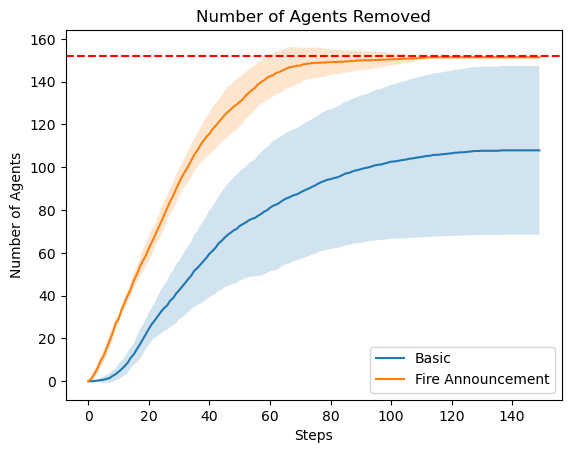

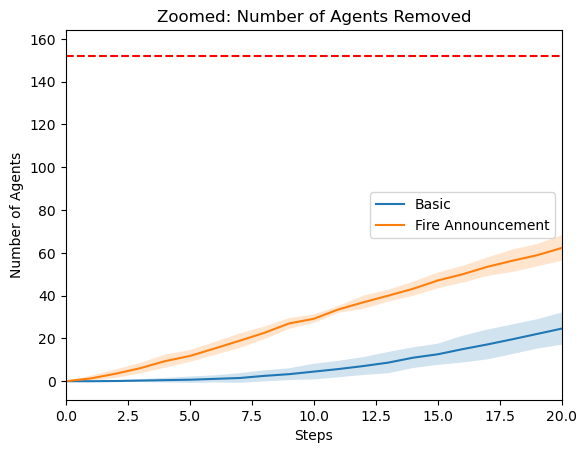

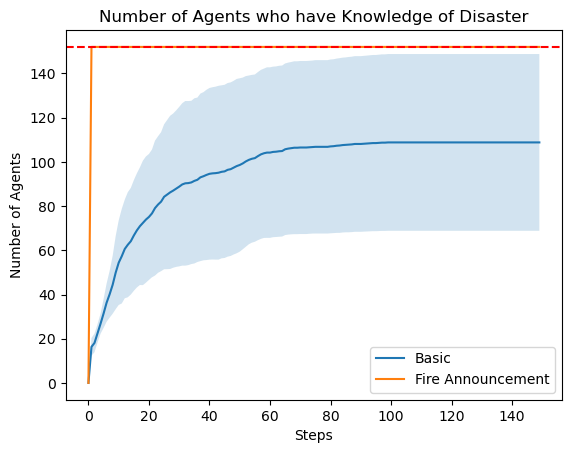

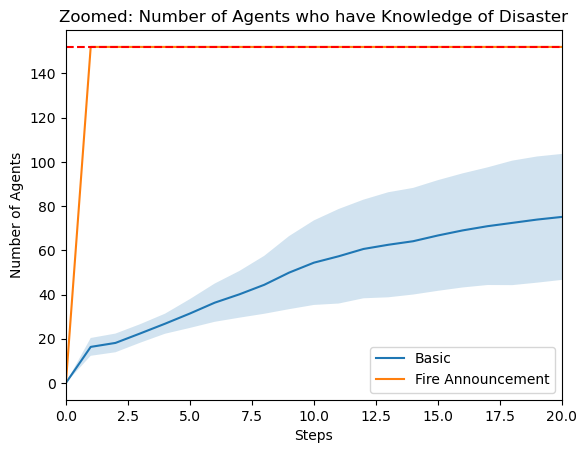

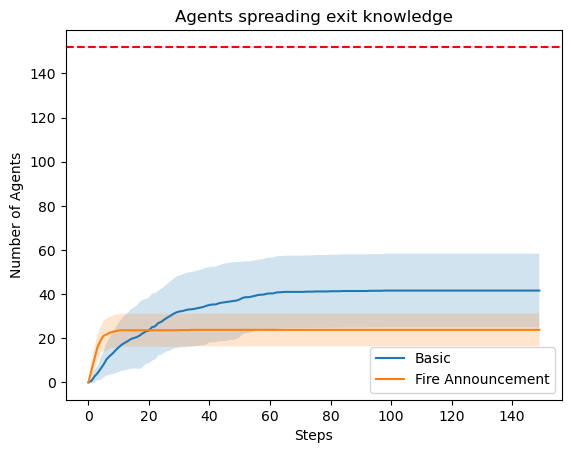

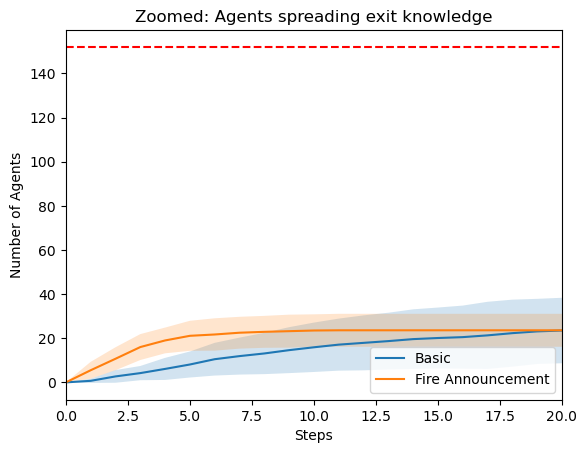

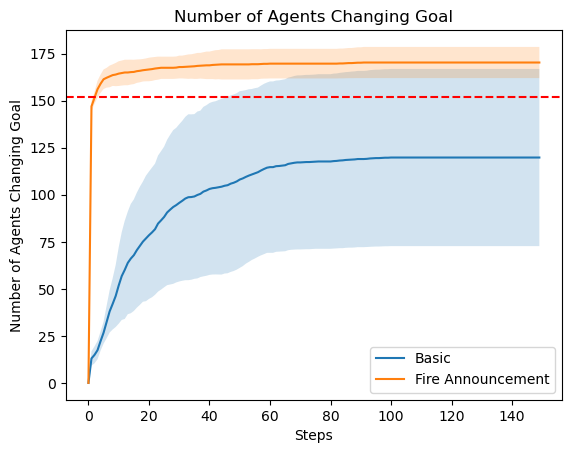

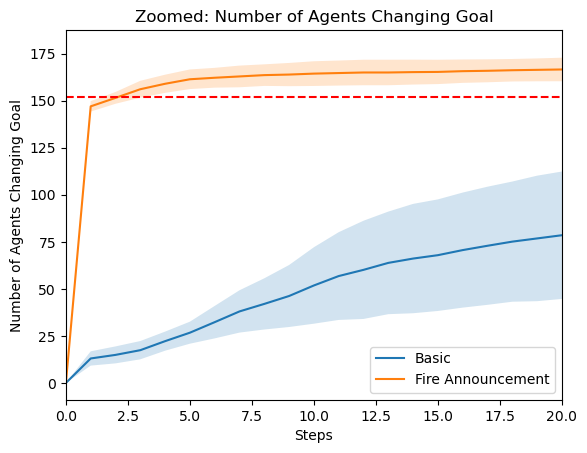

In [28]:
plot_csv("basic_removed.csv", "fire_anouncement_removed.csv", "Basic", "Fire Announcement", "Number of Agents Removed")
plot_csv("basic_know_fire.csv", "fire_anouncement_know_fire.csv", "Basic", "Fire Announcement", "Number of Agents who have Knowledge of Disaster")
plot_csv("basic_exit_spread.csv", "fire_anouncement_exit_spread.csv", "Basic", "Fire Announcement", "Agents spreading exit knowledge")
plot_csv("basic_change_goal.csv", "fire_anouncement_change_goal.csv", "Basic", "Fire Announcement", "Number of Agents Changing Goal", "Number of Agents Changing Goal")

# Intervention 3

In [29]:
evacuator_present = True
evacuator_radius = social_radius * 4

In [30]:
#Run model without visualization
server = ModularServer(CrowdModel, [grid], "Crowd Model", {"width": width, "height": height, "N": N, 'p_env_knowledge_params': p_env_knowledge_params, "fire_radius": fire_radius, 'social_radius': social_radius, 'p_spreading': p_spreading, 'p_spreading_environment': p_spreading_environment, 'exits': exits, 'evacuator_present':True, 'evacuator_radius':evacuator_radius})

num_runs = 10

# Initialize an empty DataFrame to store all data
all_data = pd.DataFrame()

all_agents_removed = []
all_agents_know_fire = []
all_exit_knowledge_spread = []
all_change_goal = []

# Run the model multiple times
for i in range(num_runs):
    print(f"Running model {i + 1}...")
    server.model = CrowdModel(width, height, N, p_env_knowledge_params, fire_radius, social_radius, p_spreading, p_spreading_environment, exits_sign, evacuator_present, evacuator_radius)
    server.model.run_model()  # Run the model
    
    data_new = server.model.datacollector.get_model_vars_dataframe()
    
    all_agents_removed.append(data_new['Agents Removed'])
    all_agents_know_fire.append(data_new["Agents Know Fire"])
    all_exit_knowledge_spread.append(data_new["Exit Knowledge Spread"])
    all_change_goal.append(data_new["Change Goal"])

# Convert to dataframe 
df_agents_removed = pd.concat(all_agents_removed, axis=1)
df_agents_know_fire = pd.concat(all_agents_know_fire, axis=1)
df_exit_knowledge_spread = pd.concat(all_exit_knowledge_spread, axis=1)
df_change_goal = pd.concat(all_change_goal, axis=1)

# Save each metric to a separate CSV file
df_agents_removed.to_csv("evacuator_removed.csv", index=False)
df_agents_know_fire.to_csv("evacuator_know_fire.csv", index=False)
df_exit_knowledge_spread.to_csv("evacuator_exit_spread.csv", index=False)
df_change_goal.to_csv("evacuator_change_goal.csv", index=False)

print("All data saved successfully!")

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Running model 1...
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Agent 81 reached the goal!
Step: 6
Agent 142 reached the goal!
Step: 7
Agent 97 reached the goal!
Agent 19 reached the goal!
Agent 98 reached the goal!
Agent 74 reached the goal!
Agent 49 reached the goal!
Agent 65 reached the goal!
Step: 8
Agent 36 reached the goal!
Agent 71 reached the goal!
Agent 58 reached the goal!
Agent 53 reached the goal!
Step: 9
Agent 20 reached the goal!
Agent 110 reached the goal!
Agent 57 reached the goal!
Agent 63 reached the goal!
Step: 10
Agent 48 reached the goal!
Agent 133 reached the goal!
Agent 37 reached the goal!
Agent 112 reached the goal!
Step: 11
Agent 86 reached the goal!
Agent 56 reached the goal!
Agent 60 reached the goal!
Agent 114 reached the goal!
Agent 24 reached the goal!
Agent 73 reached the goal!
Agent 32 reached the goal!
Step: 12
Agent 96 reached the goal!
Agent 93 reached the goal!
Agent 123 reached the goal!
Step: 13
Agent 126 reached the goal!
Agent 99 reached the goal!
Ag

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 1
Step: 2
Agent 4 reached the goal!
Step: 3
Agent 55 reached the goal!
Step: 4
Agent 101 reached the goal!
Agent 78 reached the goal!
Step: 5
Step: 6
Agent 151 reached the goal!
Agent 74 reached the goal!
Step: 7
Agent 70 reached the goal!
Agent 36 reached the goal!
Step: 8
Agent 76 reached the goal!
Agent 68 reached the goal!
Step: 9
Agent 123 reached the goal!
Agent 50 reached the goal!
Agent 124 reached the goal!
Agent 42 reached the goal!
Step: 10
Agent 64 reached the goal!
Agent 29 reached the goal!
Agent 85 reached the goal!
Agent 11 reached the goal!
Agent 82 reached the goal!
Step: 11
Agent 35 reached the goal!
Agent 71 reached the goal!
Step: 12
Agent 132 reached the goal!
Agent 131 reached the goal!
Agent 65 reached the goal!
Agent 86 reached the goal!
Agent 103 reached the goal!
Agent 48 reached the goal!
Step: 13
Agent 27 reached the goal!
Agent 34 reached the goal!
Step: 14
Agent 53 reached the goal!
Agent 47 reached the goal!
Agent 72 reached the goal!
Agent 109 rea

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 2
Step: 3
Step: 4
Agent 126 reached the goal!
Step: 5
Agent 56 reached the goal!
Agent 102 reached the goal!
Step: 6
Step: 7
Agent 0 reached the goal!
Agent 68 reached the goal!
Agent 99 reached the goal!
Step: 8
Agent 91 reached the goal!
Agent 9 reached the goal!
Agent 23 reached the goal!
Step: 9
Agent 31 reached the goal!
Agent 7 reached the goal!
Step: 10
Agent 55 reached the goal!
Agent 98 reached the goal!
Agent 47 reached the goal!
Step: 11
Agent 145 reached the goal!
Agent 48 reached the goal!
Agent 138 reached the goal!
Step: 12
Agent 13 reached the goal!
Agent 59 reached the goal!
Agent 123 reached the goal!
Agent 119 reached the goal!
Step: 13
Agent 16 reached the goal!
Agent 111 reached the goal!
Step: 14
Agent 96 reached the goal!
Agent 105 reached the goal!
Agent 71 reached the goal!
Agent 26 reached the goal!
Agent 2 reached the goal!
Step: 15
Agent 19 reached the goal!
Agent 97 reached the goal!
Agent 4 reached the goal!
Agent 140 reached the goal!
Step: 16
Agent

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Agent 113 reached the goal!
Step: 7
Agent 93 reached the goal!
Agent 69 reached the goal!
Agent 135 reached the goal!
Step: 8
Agent 44 reached the goal!
Agent 108 reached the goal!
Agent 150 reached the goal!
Step: 9
Agent 133 reached the goal!
Agent 98 reached the goal!
Agent 103 reached the goal!
Step: 10
Agent 71 reached the goal!
Agent 75 reached the goal!
Agent 85 reached the goal!
Step: 11
Agent 84 reached the goal!
Agent 16 reached the goal!
Agent 140 reached the goal!
Agent 7 reached the goal!
Agent 118 reached the goal!
Step: 12
Agent 67 reached the goal!
Agent 74 reached the goal!
Agent 88 reached the goal!
Step: 13
Agent 91 reached the goal!
Agent 90 reached the goal!
Step: 14
Agent 58 reached the goal!
Agent 141 reached the goal!
Agent 5 reached the goal!
Agent 11 reached the goal!
Agent 23 reached the goal!
Step: 15
Agent 139 reached the goal!
Agent 12 reached the goal!
Agent 49 reached the goal!
Agent 78 reached the goal!
Step: 16
A

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Agent 139 reached the goal!
Agent 132 reached the goal!
Step: 8
Agent 20 reached the goal!
Agent 68 reached the goal!


/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Agent 117 reached the goal!
Step: 9
Agent 123 reached the goal!
Agent 48 reached the goal!
Agent 126 reached the goal!
Agent 89 reached the goal!
Step: 10
Agent 75 reached the goal!
Agent 55 reached the goal!
Step: 11
Agent 95 reached the goal!
Agent 49 reached the goal!
Agent 11 reached the goal!
Agent 78 reached the goal!
Step: 12
Agent 151 reached the goal!
Agent 114 reached the goal!
Agent 116 reached the goal!
Agent 4 reached the goal!
Step: 13
Agent 5 reached the goal!
Agent 119 reached the goal!
Agent 98 reached the goal!
Step: 14
Agent 97 reached the goal!
Agent 127 reached the goal!
Agent 136 reached the goal!
Step: 15
Agent 96 reached the goal!
Agent 22 reached the goal!
Agent 53 reached the goal!
Step: 16
Agent 15 reached the goal!
Agent 42 reached the goal!
Agent 80 reached the goal!
Agent 73 reached the goal!
Agent 67 reached the goal!
Agent 70 reached the goal!
Agent 85 reached the goal!
Step: 17
Agent 111 reached the goal!
Agent 72 reached the goal!
Step: 18
Agent 51 rea

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 1
Step: 2
Agent 151 reached the goal!
Step: 3
Agent 84 reached the goal!
Step: 4
Step: 5
Step: 6
Agent 38 reached the goal!
Agent 74 reached the goal!
Step: 7
Step: 8
Agent 43 reached the goal!
Agent 135 reached the goal!


/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Agent 143 reached the goal!
Step: 9
Agent 61 reached the goal!
Agent 89 reached the goal!
Agent 71 reached the goal!
Step: 10
Agent 7 reached the goal!
Agent 125 reached the goal!
Agent 52 reached the goal!
Agent 40 reached the goal!
Agent 73 reached the goal!
Step: 11
Agent 66 reached the goal!
Step: 12
Agent 8 reached the goal!
Agent 63 reached the goal!
Agent 83 reached the goal!
Agent 31 reached the goal!
Step: 13
Agent 98 reached the goal!
Agent 96 reached the goal!
Agent 64 reached the goal!
Agent 119 reached the goal!
Agent 129 reached the goal!
Step: 14
Agent 147 reached the goal!
Agent 133 reached the goal!
Step: 15
Agent 95 reached the goal!
Agent 6 reached the goal!
Agent 117 reached the goal!
Agent 97 reached the goal!
Agent 33 reached the goal!
Step: 16
Agent 50 reached the goal!
Agent 65 reached the goal!
Agent 32 reached the goal!
Agent 35 reached the goal!
Agent 49 reached the goal!
Step: 17
Agent 85 reached the goal!
Step: 18
Agent 127 reached the goal!
Agent 106 reach

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 1
Step: 2
Step: 3
Agent 122 reached the goal!
Step: 4
Step: 5
Step: 6
Agent 147 reached the goal!
Agent 134 reached the goal!
Step: 7
Agent 25 reached the goal!
Agent 113 reached the goal!
Agent 114 reached the goal!
Step: 8
Agent 14 reached the goal!
Agent 116 reached the goal!
Agent 16 reached the goal!
Step: 9
Agent 96 reached the goal!
Agent 17 reached the goal!
Agent 127 reached the goal!
Agent 68 reached the goal!
Step: 10
Agent 84 reached the goal!
Agent 88 reached the goal!
Step: 11
Agent 148 reached the goal!
Agent 124 reached the goal!
Agent 133 reached the goal!
Agent 87 reached the goal!
Step: 12
Agent 92 reached the goal!
Agent 91 reached the goal!
Step: 13
Agent 81 reached the goal!
Agent 30 reached the goal!
Agent 109 reached the goal!
Agent 20 reached the goal!
Step: 14
Agent 104 reached the goal!
Agent 21 reached the goal!
Agent 1 reached the goal!
Agent 115 reached the goal!
Agent 15 reached the goal!
Step: 15
Agent 138 reached the goal!
Agent 150 reached the go

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Agent 130 reached the goal!
Agent 51 reached the goal!
Step: 8
Agent 66 reached the goal!
Step: 9
Agent 4 reached the goal!
Agent 98 reached the goal!
Agent 99 reached the goal!
Step: 10
Agent 145 reached the goal!
Agent 123 reached the goal!


/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:211: RuntimeWarning: invalid value encountered in divide
  desired_direction = np.array(desired_direction) / np.linalg.norm(desired_direction)


Agent 62 reached the goal!
Step: 11
Agent 77 reached the goal!
Agent 86 reached the goal!
Agent 29 reached the goal!
Agent 113 reached the goal!
Agent 74 reached the goal!
Step: 12
Agent 73 reached the goal!
Agent 34 reached the goal!
Agent 65 reached the goal!
Agent 21 reached the goal!
Agent 82 reached the goal!
Agent 10 reached the goal!
Step: 13
Agent 50 reached the goal!
Step: 14
Agent 132 reached the goal!
Agent 46 reached the goal!
Agent 92 reached the goal!
Agent 76 reached the goal!
Agent 102 reached the goal!
Agent 126 reached the goal!
Agent 71 reached the goal!
Agent 136 reached the goal!
Step: 15
Agent 37 reached the goal!
Agent 55 reached the goal!
Agent 61 reached the goal!
Step: 16
Agent 42 reached the goal!
Agent 150 reached the goal!
Agent 18 reached the goal!
Agent 144 reached the goal!
Agent 88 reached the goal!
Step: 17
Agent 90 reached the goal!
Agent 111 reached the goal!
Agent 146 reached the goal!
Agent 131 reached the goal!
Agent 134 reached the goal!
Step: 18

/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 1
Step: 2
Step: 3
Agent 149 reached the goal!
Step: 4
Agent 56 reached the goal!
Step: 5
Agent 107 reached the goal!
Step: 6
Agent 52 reached the goal!
Agent 93 reached the goal!
Step: 7
Agent 134 reached the goal!
Agent 81 reached the goal!
Step: 8
Agent 34 reached the goal!
Agent 66 reached the goal!
Agent 22 reached the goal!
Step: 9
Agent 62 reached the goal!
Agent 24 reached the goal!
Agent 59 reached the goal!
Step: 10
Agent 100 reached the goal!
Agent 58 reached the goal!
Agent 25 reached the goal!
Agent 78 reached the goal!
Step: 11
Agent 148 reached the goal!
Agent 141 reached the goal!
Step: 12
Agent 138 reached the goal!
Agent 98 reached the goal!
Agent 11 reached the goal!
Agent 19 reached the goal!
Agent 120 reached the goal!
Step: 13
Agent 75 reached the goal!
Agent 139 reached the goal!
Agent 99 reached the goal!
Agent 70 reached the goal!
Step: 14
Agent 38 reached the goal!
Agent 46 reached the goal!
Agent 14 reached the goal!
Step: 15
Agent 119 reached the goal!


/home/guoda/programming/ABM/agent_based_modeling/social_force/social_force_model.py:437: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Step: 1
Step: 2
Step: 3
Agent 106 reached the goal!
Step: 4
Agent 30 reached the goal!
Step: 5
Agent 77 reached the goal!
Step: 6
Agent 70 reached the goal!
Agent 75 reached the goal!
Agent 115 reached the goal!
Step: 7
Agent 112 reached the goal!
Agent 140 reached the goal!
Agent 68 reached the goal!
Agent 129 reached the goal!
Step: 8
Agent 128 reached the goal!
Agent 51 reached the goal!
Step: 9
Agent 55 reached the goal!
Agent 131 reached the goal!
Agent 63 reached the goal!
Agent 126 reached the goal!
Agent 22 reached the goal!
Agent 56 reached the goal!
Step: 10
Agent 67 reached the goal!
Step: 11
Agent 111 reached the goal!
Agent 79 reached the goal!
Agent 121 reached the goal!
Step: 12
Agent 145 reached the goal!
Agent 18 reached the goal!
Agent 109 reached the goal!
Agent 125 reached the goal!
Agent 1 reached the goal!
Step: 13
Agent 137 reached the goal!
Agent 95 reached the goal!
Step: 14
Agent 123 reached the goal!
Agent 4 reached the goal!
Agent 107 reached the goal!
Step:

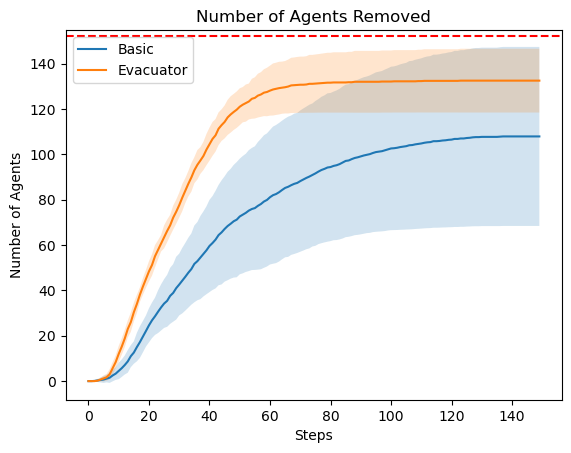

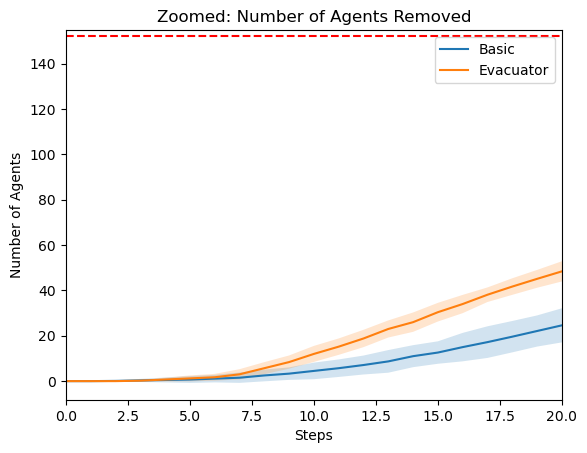

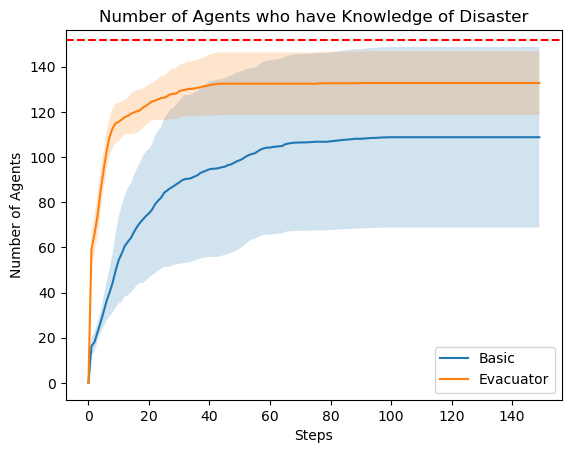

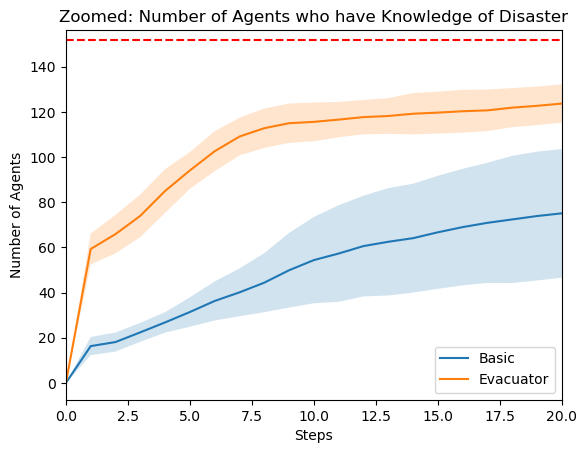

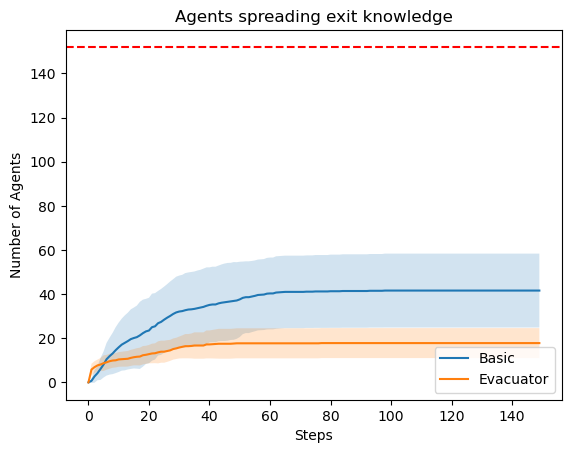

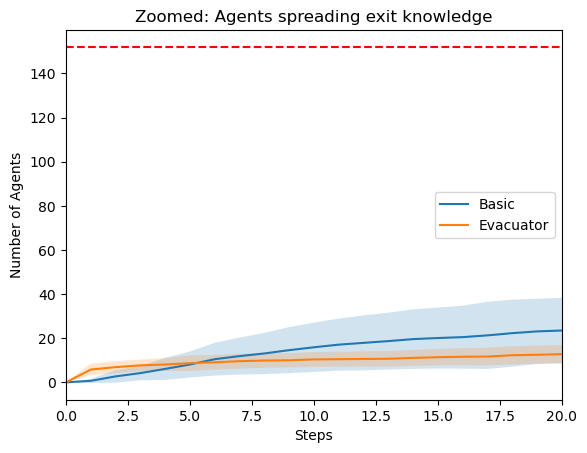

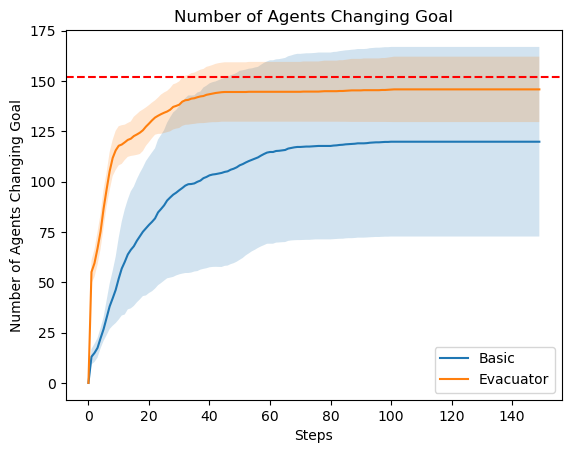

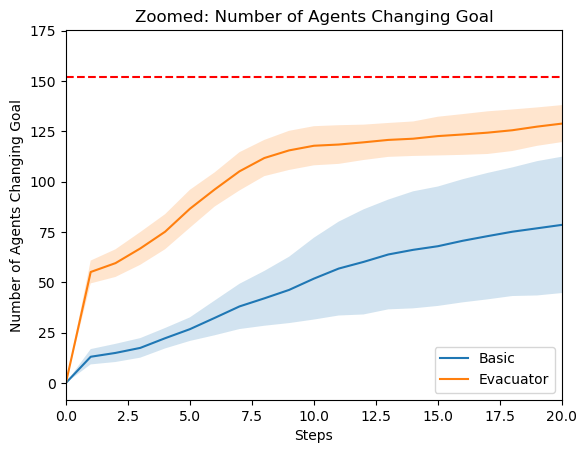

In [31]:
plot_csv("basic_removed.csv", "evacuator_removed.csv", "Basic", "Evacuator", "Number of Agents Removed")
plot_csv("basic_know_fire.csv", "evacuator_know_fire.csv", "Basic", "Evacuator", "Number of Agents who have Knowledge of Disaster")
plot_csv("basic_exit_spread.csv", "evacuator_exit_spread.csv",  "Basic", "Evacuator", "Agents spreading exit knowledge")
plot_csv("basic_change_goal.csv", "evacuator_change_goal.csv", "Basic", "Evacuator", "Number of Agents Changing Goal", "Number of Agents Changing Goal")

In [32]:
# server = ModularServer(CrowdModel, [grid], "Crowd Model", {"width": width, "height": height, "N": N, "fire_radius": fire_radius, 'social_radius': social_radius, 'p_spreading': p_spreading, 'p_spreading_environment': p_spreading_environment, 'p_env_knowledge_params': p_env_knowledge_params, 'exits': exits, 'evacuator': True})
# server.port = 9987
# server.launch()

# Plot all interventions together

In [33]:
# update the parameters fontsizes
plt.rcParams.update({'font.size': 14})

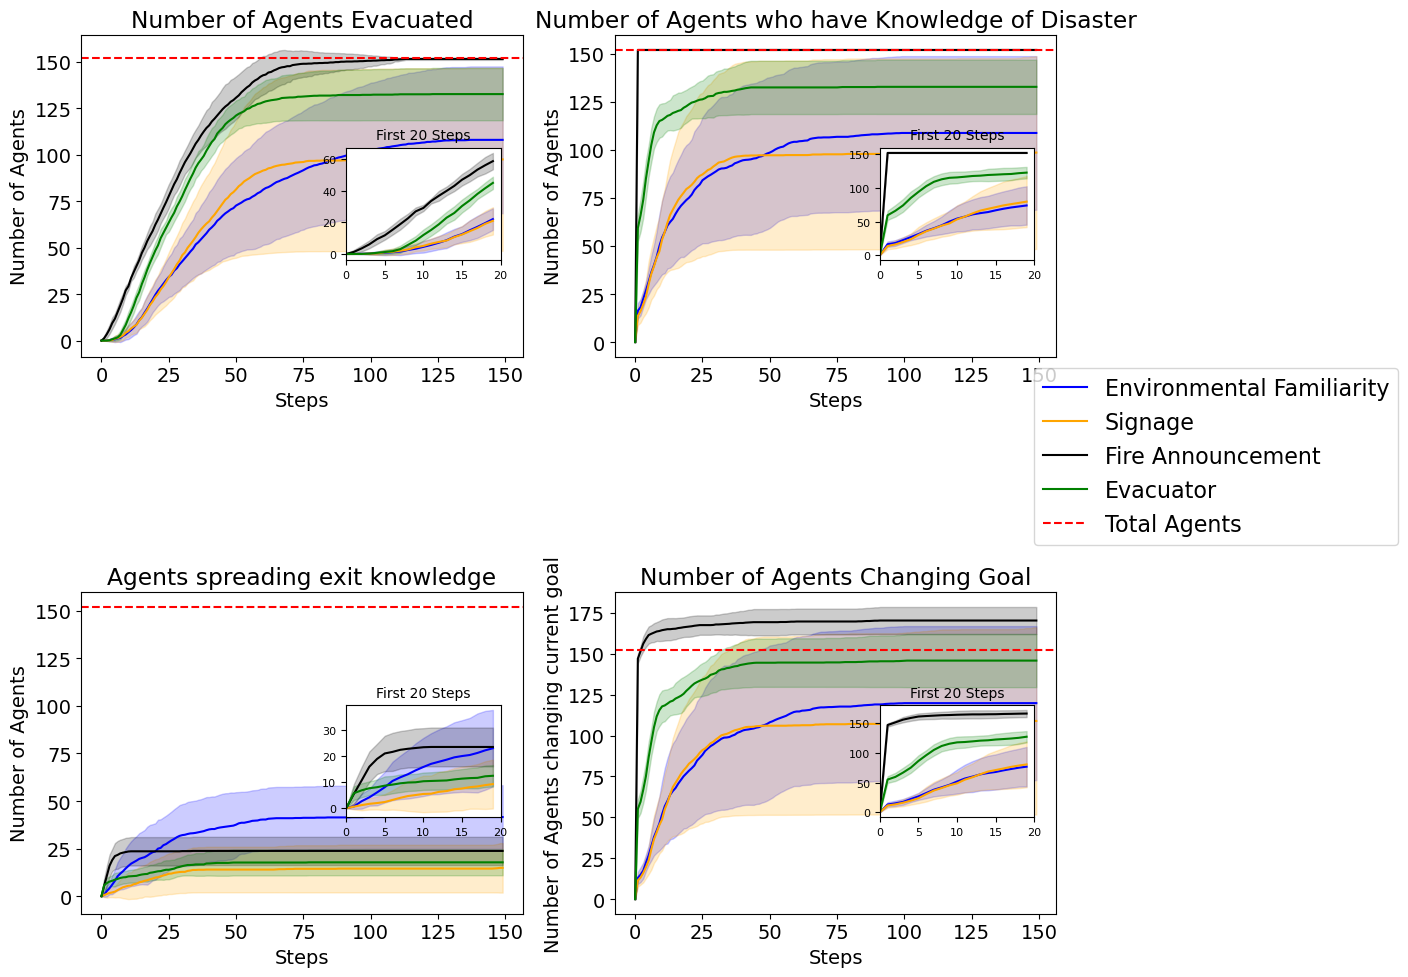

In [34]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Load data
basic_removed = pd.read_csv("basic_removed.csv")
signage_removed = pd.read_csv("signage_removed.csv")
fire_anouncement_removed = pd.read_csv("fire_anouncement_removed.csv")
evacuator_removed = pd.read_csv("evacuator_removed.csv")

basic_fire = pd.read_csv("basic_know_fire.csv")
signage_fire = pd.read_csv("signage_know_fire.csv")
fire_anouncement_fire = pd.read_csv("fire_anouncement_know_fire.csv")
evacuator_fire = pd.read_csv("evacuator_know_fire.csv")

basic_spread = pd.read_csv("basic_exit_spread.csv")
signage_spread = pd.read_csv("signage_exit_spread.csv")
fire_anouncement_spread = pd.read_csv("fire_anouncement_exit_spread.csv")
evacuator_spread = pd.read_csv("evacuator_exit_spread.csv")

basic_goal = pd.read_csv("basic_change_goal.csv")
signage_goal = pd.read_csv("signage_change_goal.csv")
fire_anouncement_goal = pd.read_csv("fire_anouncement_change_goal.csv")
evacuator_goal = pd.read_csv("evacuator_change_goal.csv")

# Create a 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Function to add an inset plot
def add_inset(ax, data_dict):
    inset_ax = ax.inset_axes([0.6, 0.3, 0.35, 0.35])  # position of the inset axes
    for label, (data, color) in data_dict.items():
        inset_ax.plot(data.mean(axis=1)[:20], label=label, color=color)
        inset_ax.fill_between(data.index[:20], data.mean(axis=1)[:20] - data.std(axis=1)[:20], data.mean(axis=1)[:20] + data.std(axis=1)[:20], alpha=0.2, color=color)
    inset_ax.set_xlim(0, 20)
    inset_ax.set_xticks(range(0, 21, 5))
    inset_ax.set_title("First 20 Steps", fontsize=10)
    inset_ax.tick_params(axis='both', which='major', labelsize=8)

# Plot removed in one plot
axs[0, 0].plot(basic_removed.mean(axis=1), label="Basic", color = "blue")
axs[0, 0].fill_between(basic_removed.index, basic_removed.mean(axis=1) - basic_removed.std(axis=1), basic_removed.mean(axis=1) + basic_removed.std(axis=1), alpha=0.2, color = "blue")
axs[0, 0].plot(signage_removed.mean(axis=1), label="Signage", color='orange')
axs[0, 0].fill_between(signage_removed.index, signage_removed.mean(axis=1) - signage_removed.std(axis=1), signage_removed.mean(axis=1) + signage_removed.std(axis=1), alpha=0.2, color='orange')
axs[0, 0].plot(fire_anouncement_removed.mean(axis=1), label="Fire Announcement", color='black')
axs[0, 0].fill_between(fire_anouncement_removed.index, fire_anouncement_removed.mean(axis=1) - fire_anouncement_removed.std(axis=1), fire_anouncement_removed.mean(axis=1) + fire_anouncement_removed.std(axis=1), alpha=0.2, color='black')
axs[0, 0].plot(evacuator_removed.mean(axis=1), label="Evacuator", color='green')
axs[0, 0].fill_between(evacuator_removed.index, evacuator_removed.mean(axis=1) - evacuator_removed.std(axis=1), evacuator_removed.mean(axis=1) + evacuator_removed.std(axis=1), alpha=0.2, color='green')
axs[0, 0].axhline(y=(N-4), color='r', linestyle='--')
# Add inset plot for removed
data_dict = { "Basic": (basic_removed, 'blue'), "Signage": (signage_removed, 'orange'), "Fire Announcement": (fire_anouncement_removed, 'black'), "Evacuator": (evacuator_removed, 'green')}
add_inset(axs[0, 0], data_dict)
axs[0, 0].set_title("Number of Agents Evacuated")
axs[0, 0].set_xlabel("Steps")
axs[0, 0].set_ylabel("Number of Agents")

# Plot fire in one plot
axs[0, 1].plot(basic_fire.mean(axis=1), label="Environmental Familiarity", color='blue')
axs[0, 1].fill_between(basic_fire.index, basic_fire.mean(axis=1) - basic_fire.std(axis=1), basic_fire.mean(axis=1) + basic_fire.std(axis=1), alpha=0.2, color='blue')
axs[0, 1].plot(signage_fire.mean(axis=1), label="Signage", color='orange')
axs[0, 1].fill_between(signage_fire.index, signage_fire.mean(axis=1) - signage_fire.std(axis=1), signage_fire.mean(axis=1) + signage_fire.std(axis=1), alpha=0.2, color='orange')
axs[0, 1].plot(fire_anouncement_fire.mean(axis=1), label="Fire Announcement", color='black')
axs[0, 1].fill_between(fire_anouncement_fire.index, fire_anouncement_fire.mean(axis=1) - fire_anouncement_fire.std(axis=1), fire_anouncement_fire.mean(axis=1) + fire_anouncement_fire.std(axis=1), alpha=0.2, color='black')
axs[0, 1].plot(evacuator_fire.mean(axis=1), label="Evacuator", color='green')
axs[0, 1].fill_between(evacuator_fire.index, evacuator_fire.mean(axis=1) - evacuator_fire.std(axis=1), evacuator_fire.mean(axis=1) + evacuator_fire.std(axis=1), alpha=0.2, color='green')
axs[0, 1].axhline(y=(N-4), color='r', linestyle='--', label="Total Agents")
# Add inset plot for fire
data_dict = { "Basic": (basic_fire, 'blue'), "Signage": (signage_fire, 'orange'), "Fire Announcement": (fire_anouncement_fire, 'black'), "Evacuator": (evacuator_fire, 'green')}
add_inset(axs[0, 1], data_dict)
axs[0, 1].legend(bbox_to_anchor=(1.8, 0), fontsize=16)
axs[0, 1].set_title("Number of Agents who have Knowledge of Disaster")
axs[0, 1].set_xlabel("Steps")
axs[0, 1].set_ylabel("Number of Agents")

# Plot spread in one plot
axs[1, 0].plot(basic_spread.mean(axis=1), label="Basic", color='blue')
axs[1, 0].fill_between(basic_spread.index, basic_spread.mean(axis=1) - basic_spread.std(axis=1), basic_spread.mean(axis=1) + basic_spread.std(axis=1), alpha=0.2, color='blue')
axs[1, 0].plot(signage_spread.mean(axis=1), label="Signage", color='orange')
axs[1, 0].fill_between(signage_spread.index, signage_spread.mean(axis=1) - signage_spread.std(axis=1), signage_spread.mean(axis=1) + signage_spread.std(axis=1), alpha=0.2, color='orange')
axs[1, 0].plot(fire_anouncement_spread.mean(axis=1), label="Fire Announcement", color='black')
axs[1, 0].fill_between(fire_anouncement_spread.index, fire_anouncement_spread.mean(axis=1) - fire_anouncement_spread.std(axis=1), fire_anouncement_spread.mean(axis=1) + fire_anouncement_spread.std(axis=1), alpha=0.2, color='black')
axs[1, 0].plot(evacuator_spread.mean(axis=1), label="Evacuator", color='green')
axs[1, 0].fill_between(evacuator_spread.index, evacuator_spread.mean(axis=1) - evacuator_spread.std(axis=1), evacuator_spread.mean(axis=1) + evacuator_spread.std(axis=1), alpha=0.2, color='green')
axs[1, 0].axhline(y=(N-4), color='r', linestyle='--')
# Add inset plot for spread
data_dict = { "Basic": (basic_spread, 'blue'), "Signage": (signage_spread, 'orange'), "Fire Announcement": (fire_anouncement_spread, 'black'), "Evacuator": (evacuator_spread, 'green')}
add_inset(axs[1, 0], data_dict)
axs[1, 0].set_title("Agents spreading exit knowledge")
axs[1, 0].set_xlabel("Steps")
axs[1, 0].set_ylabel("Number of Agents")

# Plot goal in one plot
axs[1, 1].plot(basic_goal.mean(axis=1), label="Basic", color='blue')
axs[1, 1].fill_between(basic_goal.index, basic_goal.mean(axis=1) - basic_goal.std(axis=1), basic_goal.mean(axis=1) + basic_goal.std(axis=1), alpha=0.2, color='blue')
axs[1, 1].plot(signage_goal.mean(axis=1), label="Signage", color='orange')
axs[1, 1].fill_between(signage_goal.index, signage_goal.mean(axis=1) - signage_goal.std(axis=1), signage_goal.mean(axis=1) + signage_goal.std(axis=1), alpha=0.2,  color='orange')
axs[1, 1].plot(fire_anouncement_goal.mean(axis=1), label="Fire Announcement", color='black')
axs[1, 1].fill_between(fire_anouncement_goal.index, fire_anouncement_goal.mean(axis=1) - fire_anouncement_goal.std(axis=1), fire_anouncement_goal.mean(axis=1) + fire_anouncement_goal.std(axis=1), alpha=0.2, color='black')
axs[1, 1].plot(evacuator_goal.mean(axis=1), label="Evacuator", color='green')
axs[1, 1].fill_between(evacuator_goal.index, evacuator_goal.mean(axis=1) - evacuator_goal.std(axis=1), evacuator_goal.mean(axis=1) + evacuator_goal.std(axis=1), alpha=0.2, color='green')
axs[1, 1].axhline(y=(N-4), color='r', linestyle='--')
# Add inset plot for goal
data_dict = { "Basic": (basic_goal, 'blue'), "Signage": (signage_goal, 'orange'), "Fire Announcement": (fire_anouncement_goal, 'black'), "Evacuator": (evacuator_goal, 'green')}
add_inset(axs[1, 1], data_dict)
axs[1, 1].set_title("Number of Agents Changing Goal")
axs[1, 1].set_xlabel("Steps")
axs[1, 1].set_ylabel("Number of Agents changing current goal")

plt.tight_layout()
plt.show()
